#Predicting Hotel Reservation Cancellations: Analyzing Key Drivers and Reducing Cancellation Rates

##1.Project Overview

The objective of this project is to predict hotel reservation cancellations and identify the key factors contributing to these cancellations. Understanding these factors enables hotel management to develop strategies to reduce cancellation rates, optimize booking policies, and enhance customer satisfaction.



##2.Data Information

The dataset includes comprehensive hotel reservation data with features such as:
* Booking_ID: Unique identifier for each booking
* no_of_adults: Number of adults
* no_of_children: Number of children
* no_of_weekend_nights: Number of weekend nights (Saturday and Sunday)
* no_of_week_nights: Number of weeknights (Monday to Friday)
* type_of_meal_plan: Type of meal plan booked
* required_car_parking_space: Indicates if a car parking space is required (0 or 1)
* room_type_reserved: Type of room reserved
* lead_time: Number of days between booking and arrival
* arrival_year: Year of arrival
* arrival_month: Month of arrival
* arrival_date: Date of arrival
* market_segment_type: Market segment type
* repeated_guest: Indicates if the guest is a repeated guest (0 or 1)
* no_of_previous_cancellations: Number of previous cancellations by the customer
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer
* avg_price_per_room: Average price per room
* no_of_special_requests: Number of special requests made
* booking_status: Indicates whether the booking was canceled or notffff


##3.Data Inspecting and Preprocessing

In [3]:
!pip install catboost

In [4]:
!pip install logitboost

In [5]:
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 4.2 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from logitboost import LogitBoost
import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import files
uploaded = files.upload()

Saving Hotel Reservations.csv to Hotel Reservations.csv


In [8]:
# Loading the dataset
file_path = 'Hotel Reservations.csv'
hotel_data = pd.read_csv(file_path)
hotel_data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [9]:
#Checking the shape of the dataset
hotel_data.shape

(36275, 19)

In [10]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [11]:
hotel_data.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
required_car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0


In [12]:
#Dropping the identifier column
hotel_data.drop(['Booking_ID'], axis=1, inplace=True)

In [13]:
hotel_data['date of arrival'] = hotel_data['arrival_year'].astype(str) + '/' + hotel_data['arrival_month'].astype(str) + '/' + hotel_data['arrival_date'].astype(str)

#type casting the date column
hotel_data['date of arrival'] = pd.to_datetime(hotel_data['date of arrival'],format='mixed', infer_datetime_format=True, errors='coerce',yearfirst=True)

#dropping the columns
hotel_data.drop(columns=['arrival_date', 'arrival_month', 'arrival_year'], inplace=True)

In [14]:
hotel_data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date of arrival
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,65.00,0,Not_Canceled,2017-10-02
1,2,0,2,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled,2018-11-06
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,60.00,0,Canceled,2018-02-28
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,0,Canceled,2018-05-20
4,2,0,1,1,Not Selected,0,Room_Type 1,48,Online,0,0,0,94.50,0,Canceled,2018-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,Online,0,0,0,167.80,1,Not_Canceled,2018-08-03
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,Online,0,0,0,90.95,2,Canceled,2018-10-17
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,Online,0,0,0,98.39,2,Not_Canceled,2018-07-01
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,Online,0,0,0,94.50,0,Canceled,2018-04-21


In [15]:
hotel_data.isnull().sum()

,0
no_of_adults,0
no_of_children,0
no_of_weekend_nights,0
no_of_week_nights,0
type_of_meal_plan,0
required_car_parking_space,0
room_type_reserved,0
lead_time,0
market_segment_type,0
repeated_guest,0


In [16]:
hotel_data.dropna(inplace=True)
hotel_data.reset_index()

,index,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date of arrival
0,0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,65.00,0,Not_Canceled,2017-10-02
1,1,2,0,2,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled,2018-11-06
2,2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,60.00,0,Canceled,2018-02-28
3,3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,0,Canceled,2018-05-20
4,4,2,0,1,1,Not Selected,0,Room_Type 1,48,Online,0,0,0,94.50,0,Canceled,2018-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36233,36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,Online,0,0,0,167.80,1,Not_Canceled,2018-08-03
36234,36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,Online,0,0,0,90.95,2,Canceled,2018-10-17
36235,36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,Online,0,0,0,98.39,2,Not_Canceled,2018-07-01
36236,36273,2,0,0,3,Not Selected,0,Room_Type 1,63,Online,0,0,0,94.50,0,Canceled,2018-04-21


In [17]:
hotel_data.duplicated().sum()

10273

In [18]:
hotel_data.shape

(36238, 16)

In [19]:
# checking for unique values in each column
hotel_data.nunique()

,0
no_of_adults,5
no_of_children,6
no_of_weekend_nights,8
no_of_week_nights,18
type_of_meal_plan,4
required_car_parking_space,2
room_type_reserved,7
lead_time,352
market_segment_type,5
repeated_guest,2


In [20]:
#checking data types
hotel_data.dtypes

,0
no_of_adults,int64
no_of_children,int64
no_of_weekend_nights,int64
no_of_week_nights,int64
type_of_meal_plan,object
required_car_parking_space,int64
room_type_reserved,object
lead_time,int64
market_segment_type,object
repeated_guest,int64


In [21]:
hotel_data.describe().T

,count,mean,min,25%,50%,75%,max,std
no_of_adults,36238.0,1.845301,0.0,2.0,2.0,2.0,4.0,0.518572
no_of_children,36238.0,0.105221,0.0,0.0,0.0,0.0,10.0,0.40254
no_of_weekend_nights,36238.0,0.810475,0.0,0.0,1.0,2.0,7.0,0.870992
no_of_week_nights,36238.0,2.204206,0.0,1.0,2.0,3.0,17.0,1.410784
required_car_parking_space,36238.0,0.030934,0.0,0.0,0.0,0.0,1.0,0.173142
lead_time,36238.0,85.27507,0.0,17.0,57.0,126.0,443.0,85.953561
repeated_guest,36238.0,0.025553,0.0,0.0,0.0,0.0,1.0,0.157801
no_of_previous_cancellations,36238.0,0.023346,0.0,0.0,0.0,0.0,13.0,0.368483
no_of_previous_bookings_not_canceled,36238.0,0.152961,0.0,0.0,0.0,0.0,58.0,1.753366
avg_price_per_room,36238.0,103.437259,0.0,80.3,99.45,120.0,540.0,35.084264


Here the minimum average price per room and number of adults is zero, which is not possible so, I will replace the price with with mean value and drop the rows with zero adults.

In [22]:
hotel_data['avg_price_per_room'].replace(0,hotel_data['avg_price_per_room'].mean(), inplace=True)

In [23]:
#drop where adults are 0
hotel_data.drop(hotel_data[hotel_data['no_of_adults'] == 0].index, inplace = True)

In [24]:
hotel_data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date of arrival
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,65.00,0,Not_Canceled,2017-10-02
1,2,0,2,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,Not_Canceled,2018-11-06
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,60.00,0,Canceled,2018-02-28
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,0,Canceled,2018-05-20
4,2,0,1,1,Not Selected,0,Room_Type 1,48,Online,0,0,0,94.50,0,Canceled,2018-04-11


##4.Exploratory Data Analysis (EDA)


###booking_status (Target Variable)

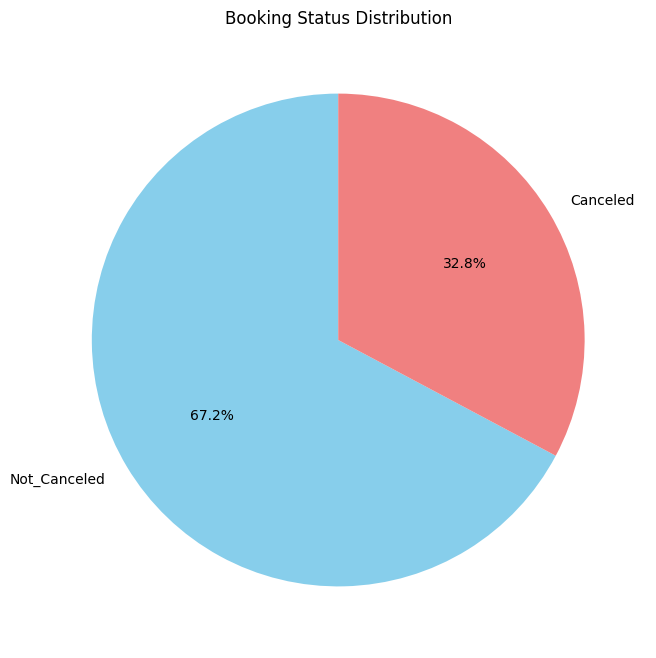

In [25]:
import matplotlib.pyplot as plt

# Assign hotel_data to a variable named data
data = hotel_data

# Get the value counts of the booking_status
booking_status_counts = data['booking_status'].value_counts()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(booking_status_counts, labels=booking_status_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])

# Set the title
ax.set_title('Booking Status Distribution')

# Show plot
plt.show()

When it comes to training a machine learning model, especially for classification tasks, the balance of the classes in your target variable is an important consideration. While a class distribution of 67.2% for "not cancel" and 32.8% for "cancel" is not perfectly balanced, it is not extremely imbalanced either.

### Guest Information

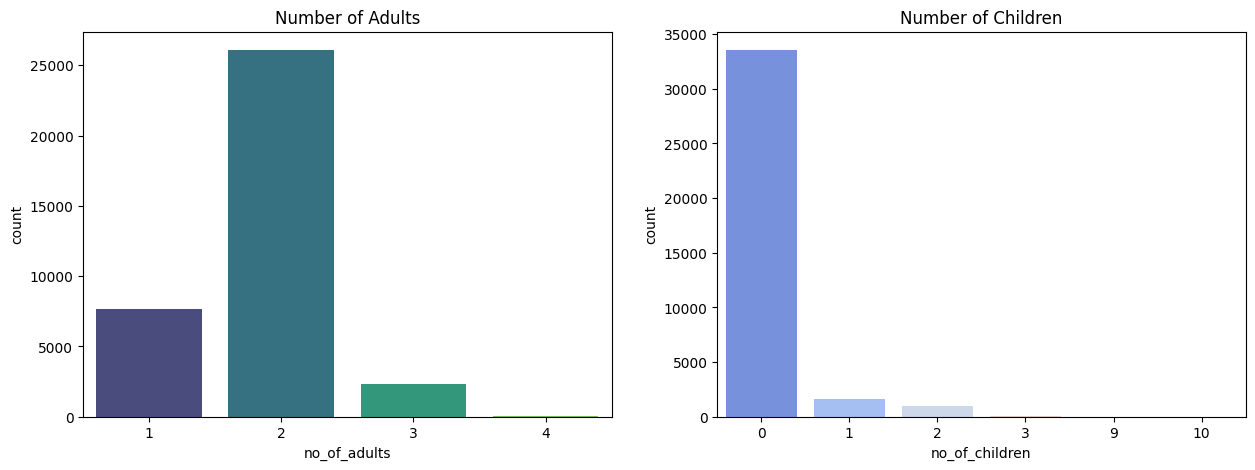

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 'Number of Adults' with a specific color
sns.countplot(x='no_of_adults', data=hotel_data, palette='viridis', ax=ax[0]).set_title('Number of Adults')

# Plot 'Number of Children' with a different color
sns.countplot(x='no_of_children', data=hotel_data, palette='coolwarm', ax=ax[1]).set_title('Number of Children')

# Show plot
plt.show()

The majority of bookings were made for 2 adults with no children which could mean that most of the bookings were made for couples. The second most common booking was for 1 adult with no children which could mean that most of the bookings were made for business trips. A few bookings were made with 1 or 2 children which could be by a family.

###Time Spent at Hotel

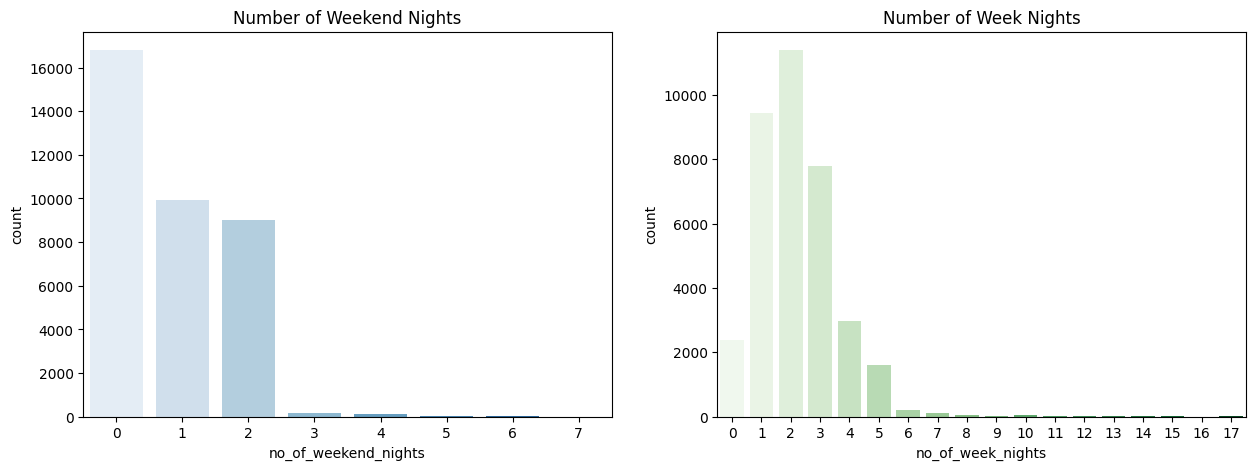

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 'Number of Weekend Nights' with a specific color palette
sns.countplot(x='no_of_weekend_nights', data=data, palette='Blues', ax=ax[0]).set_title('Number of Weekend Nights')

# Plot 'Number of Week Nights' with a different color palette
sns.countplot(x='no_of_week_nights', data=data, palette='Greens', ax=ax[1]).set_title('Number of Week Nights')

# Show plot
plt.show()

The majority of the hotel bookings were for 1 or 2 nights. However, considerable number of bookings take place for the weekends. From this I assume that the bookings for the weekends were for vacation and the those for the weekdays were for business trips or for other reasons.

###Date of Arrival

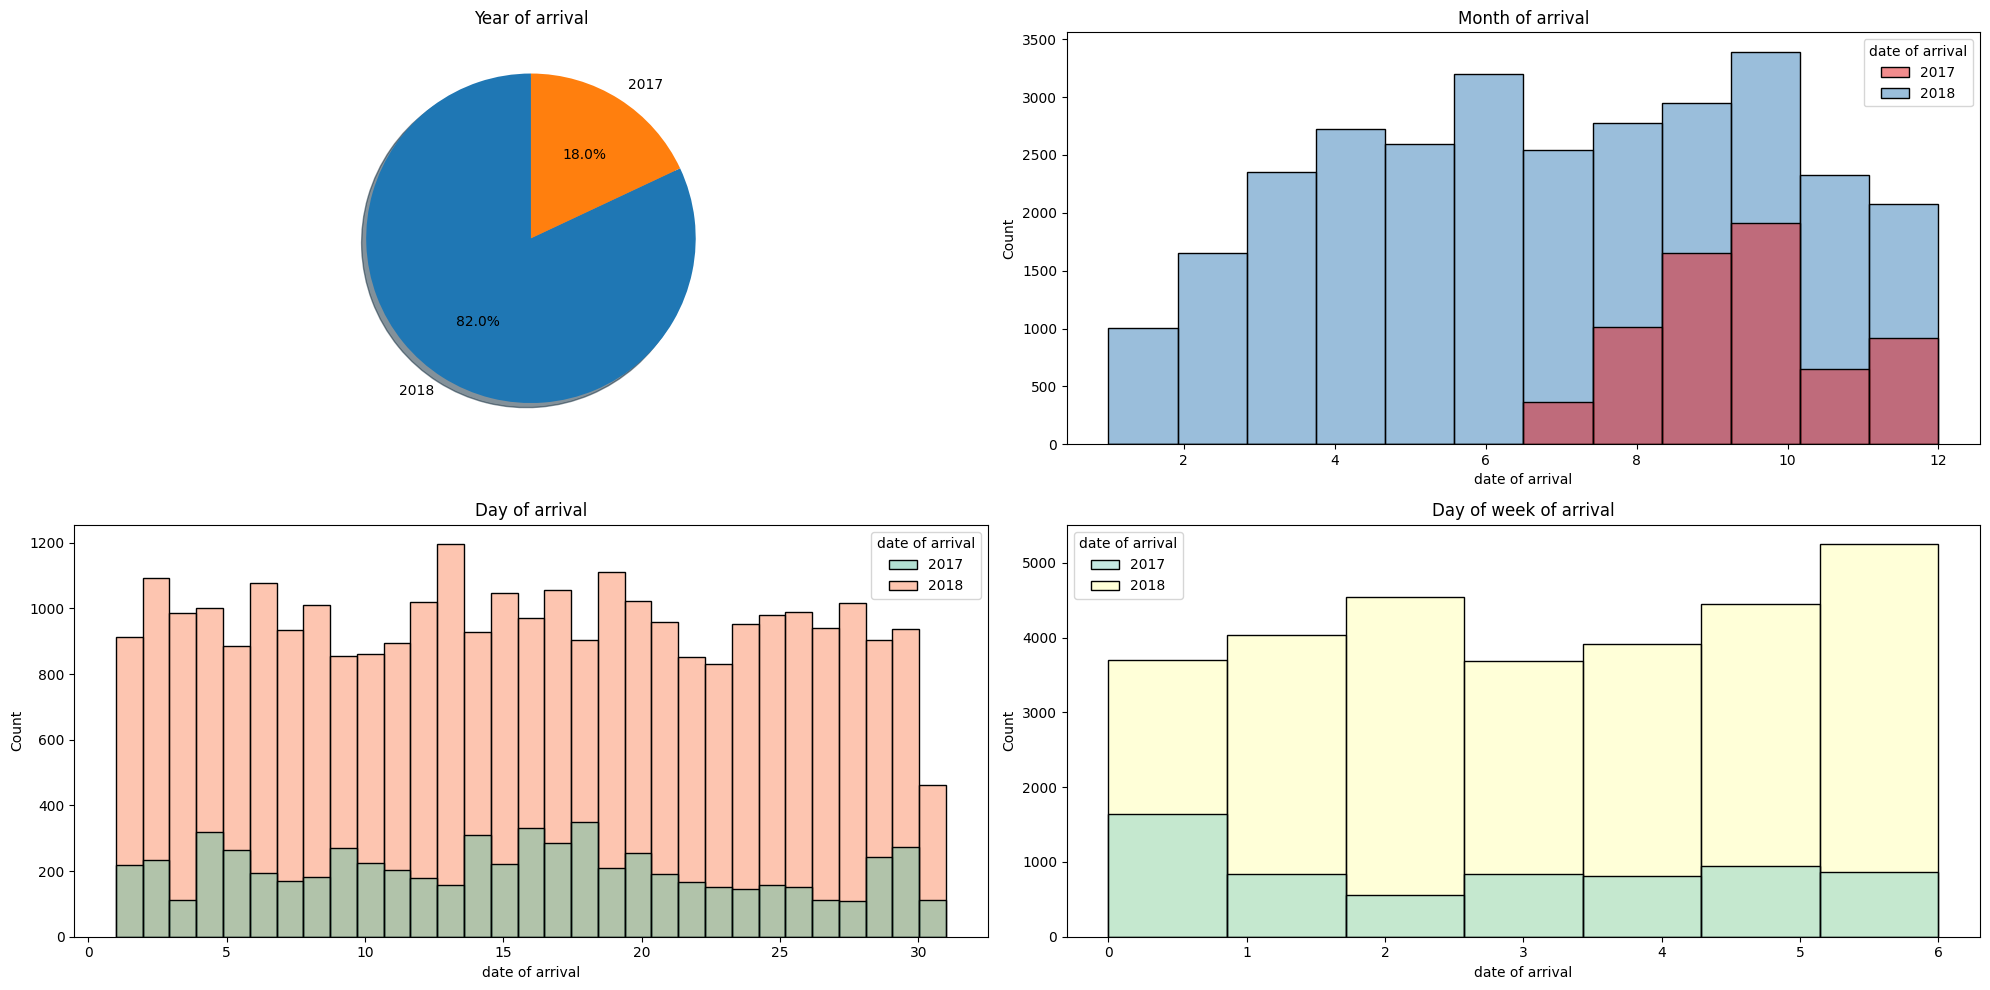

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Year of arrival
ax[0, 0].pie(data['date of arrival'].dt.year.value_counts(), labels=[2018, 2017], autopct='%1.1f%%', shadow=True, startangle=90)
ax[0, 0].set_title('Year of arrival')

# Month of arrival
sns.histplot(x=data['date of arrival'].dt.month, ax=ax[0, 1], bins=12, hue=data['date of arrival'].dt.year, palette='Set1').set_title('Month of arrival')

# Day of arrival
sns.histplot(x=data['date of arrival'].dt.day, ax=ax[1, 0], bins=31, hue=data['date of arrival'].dt.year, palette='Set2').set_title('Day of arrival')

# Day of week of arrival
sns.histplot(x=data['date of arrival'].dt.dayofweek, ax=ax[1, 1], bins=7, hue=data['date of arrival'].dt.year, palette='Set3').set_title('Day of week of arrival')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

The majority of the bookings were in 2018, i.e. 82%. In both the years the month of October had most booings as compared to other months. In 2017 nearly 2000 bookings in october and in 2018 nearly 3500. In addtion to that June had highest number of bookings after October. Coming to the days of the month, In 2017, 4,14,16,18 days from the month had the most reservations. In 2018, 2,7,14,19 days of the month had the most reservations. In the days of the week, Sundays had the highest number of reservations in 2017, whereas the Saturdays had the highest number of reservations in 2018.

From the above visualizations, we can conclude that more bookings were made in June and October particulary on the second and third weeks and during the weekends.

###Services

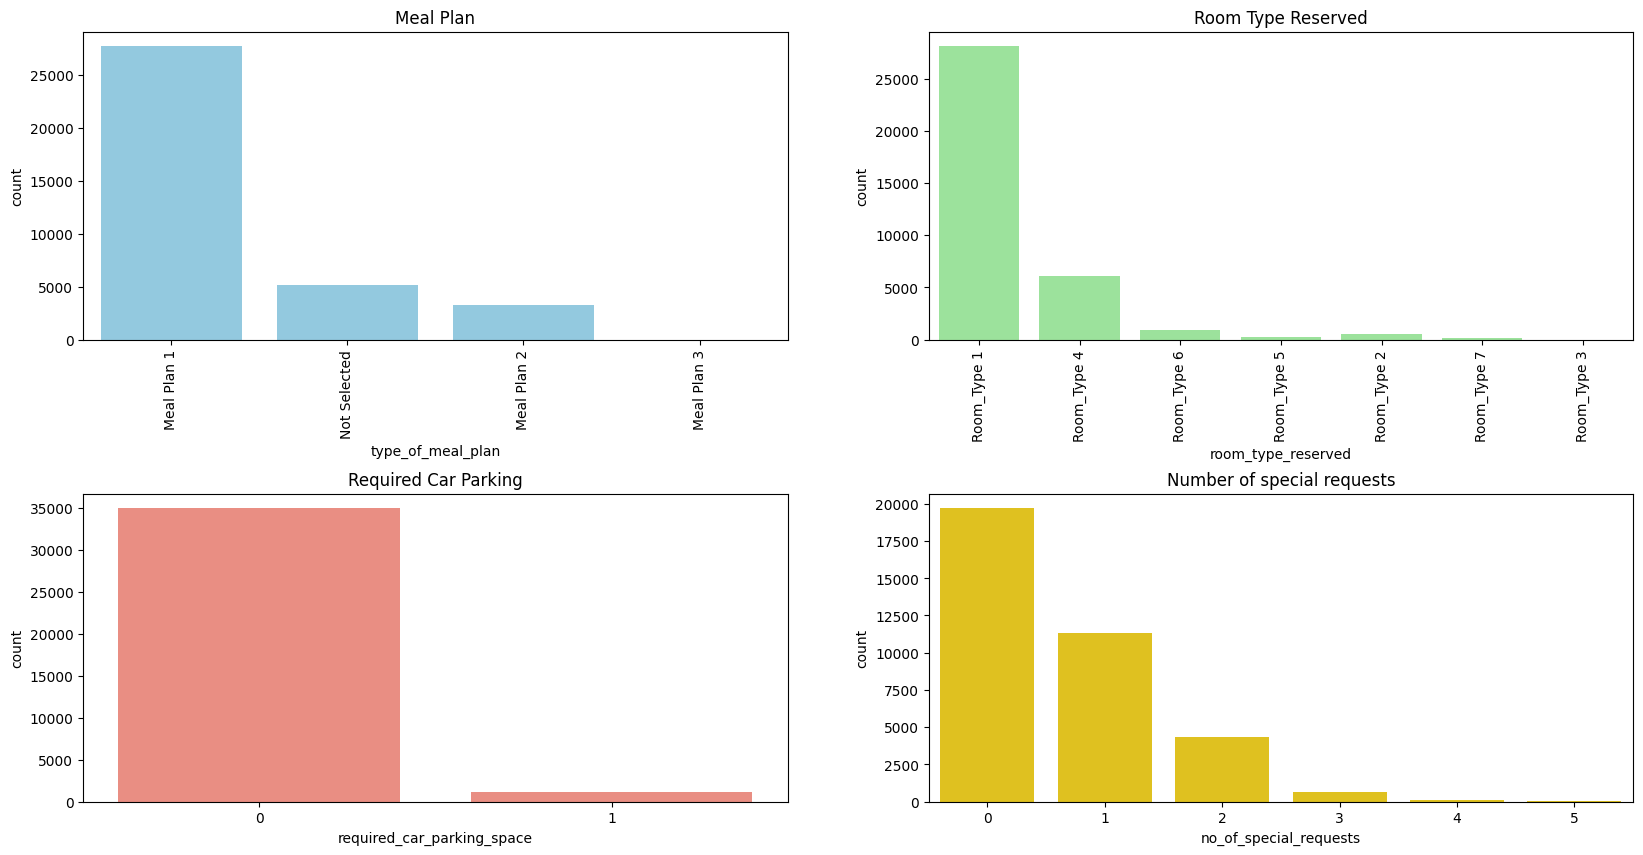

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)

# Plot 'Meal Plan' with a specific color
sns.countplot(x='type_of_meal_plan', data=data, color='skyblue', ax=ax[0, 0]).set_title('Meal Plan')
ax[0, 0].xaxis.set_tick_params(rotation=90)

# Plot 'Room Type Reserved' with a different color
sns.countplot(x='room_type_reserved', data=data, color='lightgreen', ax=ax[0, 1]).set_title('Room Type Reserved')
ax[0, 1].xaxis.set_tick_params(rotation=90)

# Plot 'Required Car Parking' with another color
sns.countplot(x='required_car_parking_space', data=data, color='salmon', ax=ax[1, 0]).set_title('Required Car Parking')

# Plot 'Number of special requests' with yet another color
sns.countplot(x='no_of_special_requests', data=data, color='gold', ax=ax[1, 1]).set_title('Number of special requests')

# Show plot
plt.show()

Majority of the guests preferred Meal Plan1 and Room Type 1 and no special requests during reservations and most of them don't require parking space. Moreover a significant number of reservations were made without specifiying the type of meal plan, which could mean that the guests might have meal outside the hotel. The required parking space graph also tells about the mode of transportation used by the guests. Most of the guests used public transport or taxi to reach the hotel.

###Lead time (days between date of reservation and date of arrival)

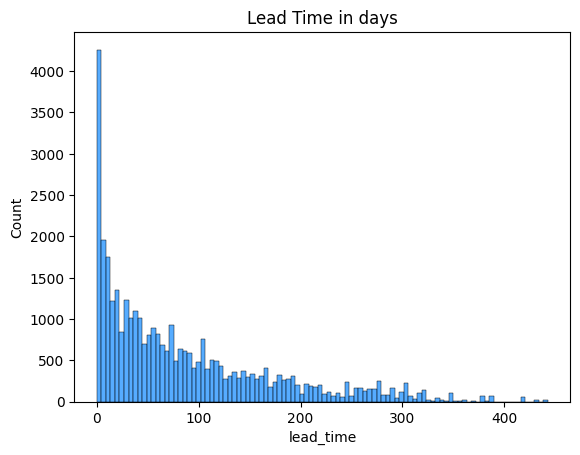

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign hotel_data to a variable named data
data = hotel_data

# Plot 'Lead Time in days' with a specific color
sns.histplot(x='lead_time', data= data , bins=100, color='dodgerblue').set_title('Lead Time in days')

# Show plot
plt.show()

This graph shows that significant number of reservations were made just one day before or on the day of arrival. In addtion to that most of the reservations were made 1 to 2 weeks before the date of arrival. However, there were also reservations made 2-3 months before the date of arrival. From this histogram, I made ab hypothesis that, the guest who have lead time very less are less likely to cancel the reservation as compared to the guest who have more lead time.

###Market Segment

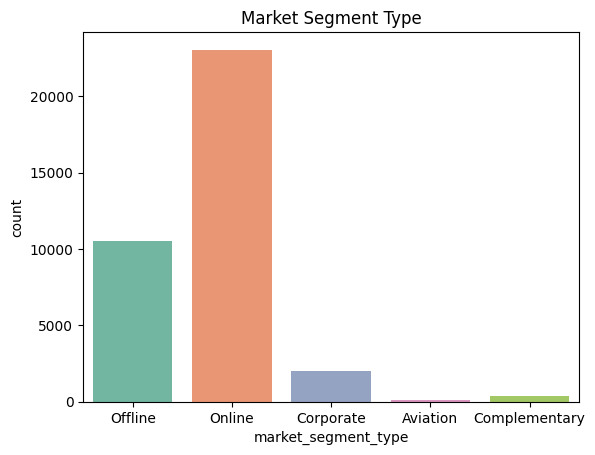

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign hotel_data to a variable named data
data = hotel_data

# Plot 'Market Segment Type' with a specific color palette
sns.countplot(x='market_segment_type', data=data, palette='Set2').set_title('Market Segment Type')

# Show plot
plt.show()

Makority of the reservations were made through online platforms which means the hotel company has more presence on travel booking platforms. The second most common way of booking was through offline, which could be on arrival at the hotel or through a travel agent. The third most common way of booking was corporate, which could be through a company. Vert few of the bookings were made by aviation companies which highlights possibility of an airport near the hotel.

###Guest's previous experience with the hotel

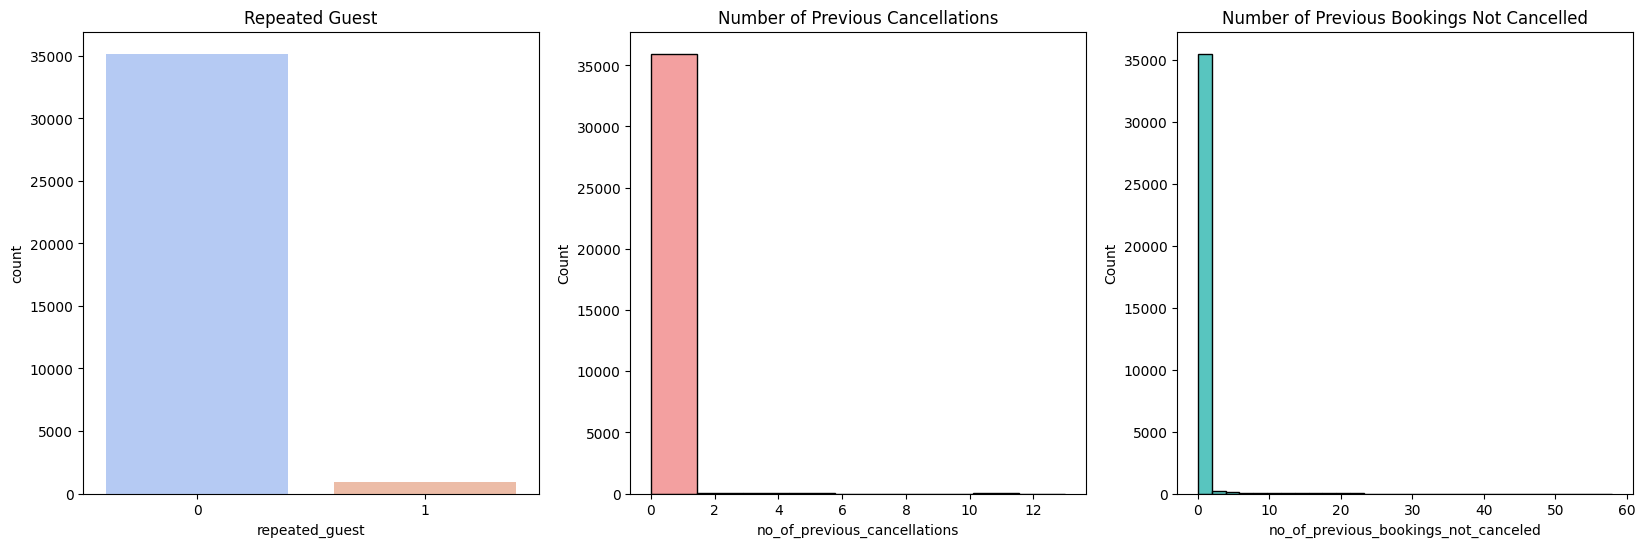

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Plot 'Repeated Guest' with a specific color palette
sns.countplot(x='repeated_guest', data=data, palette='coolwarm', ax=ax[0]).set_title('Repeated Guest')

# Plot 'Number of Previous Cancellations' with a specific color
sns.histplot(x='no_of_previous_cancellations', data=data, bins=9, color='lightcoral', ax=ax[1]).set_title('Number of Previous Cancellations')

# Plot 'Number of Previous Bookings Not Cancelled' with another specific color
sns.histplot(x='no_of_previous_bookings_not_canceled', data=data, bins=30, color='lightseagreen', ax=ax[2]).set_title('Number of Previous Bookings Not Cancelled')

# Show plot
plt.show()

Majority of the reservations made at the hotel are by new guest, very few are the repeated guests at the hotel. This highlights the problem in the customer retention at the hotel. The hotel should focus on providing better services to the guests so that they would like to visit the hotel again. Since majority of the guest are new, so majority of the dataset has 0 pervious bookings cancellation. However, on a little bit closer look, we can see that there some guests who have cancelled their previous bookings.

###Average room price

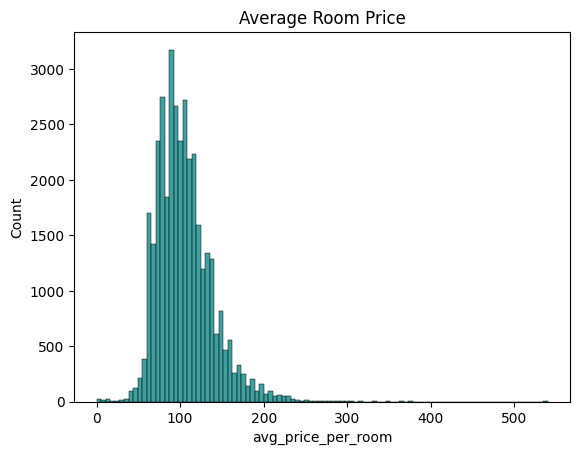

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign hotel_data to a variable named data
data = hotel_data

# Plot 'Average Room Price' with a specific color
sns.histplot(x='avg_price_per_room', data=data, bins=100, color='teal').set_title('Average Room Price')

# Show plot
plt.show()

Majority of the reservations made had room price between 75 to 150. Very few of the reservations had room price more than 200.

###Guest Information and Cancellation

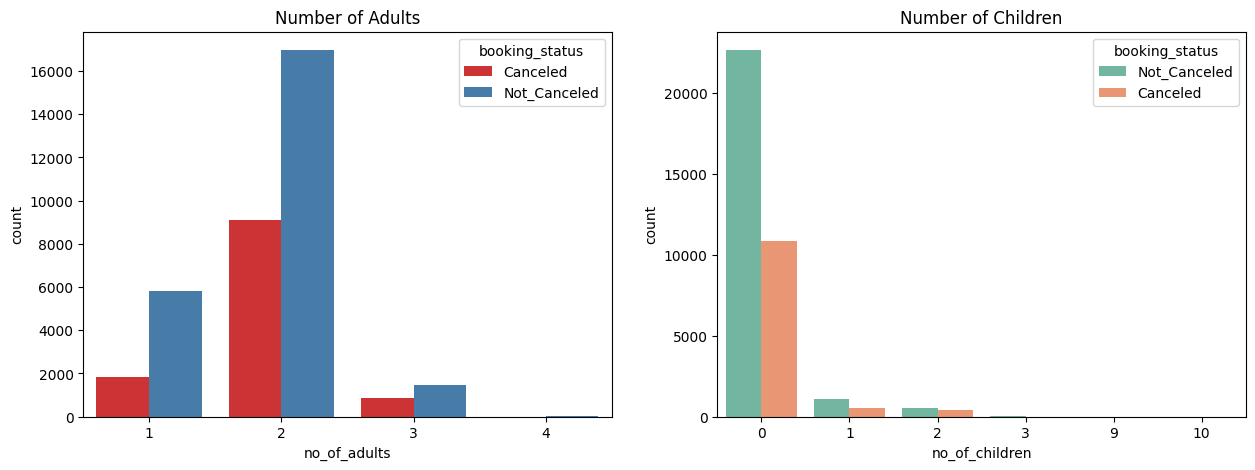

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 'Number of Adults' with a specific color palette
sns.countplot(x='no_of_adults', data=data, ax=ax[0], hue='booking_status', palette='Set1').set_title('Number of Adults')

# Plot 'Number of Children' with a different color palette
sns.countplot(x='no_of_children', data=data, ax=ax[1], hue='booking_status', palette='Set2').set_title('Number of Children')

# Show plot
plt.show()

Majority of the reservation cancellations were made when the reservation was made for two adults, probably with no children. The second most common cancellation was made when the reservation was made for one adult. However, the number of cancellation reduces, when the reservation includes children and had more than 2 adults.

###Time Spent at Hotel and Cancellation

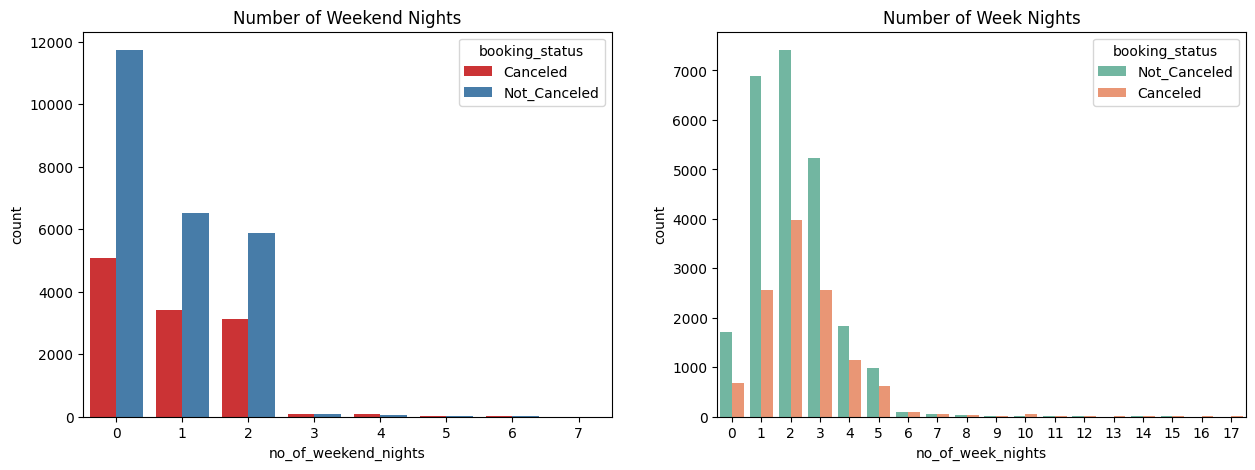

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 'Number of Weekend Nights' with a specific color palette
sns.countplot(x='no_of_weekend_nights', data=data, ax=ax[0], hue='booking_status', palette='Set1').set_title('Number of Weekend Nights')

# Plot 'Number of Week Nights' with a different color palette
sns.countplot(x='no_of_week_nights', data=data, ax=ax[1], hue='booking_status', palette='Set2').set_title('Number of Week Nights')

# Show plot
plt.show()

The reservations made to spend 1 or 2 weekends nights have lower count of being cancelled. As compared to the reservations made to spend 2 weekdays at the hotel had the highest cancellation count followed by 1 and 3 week days. This could mean that guest could cancel their reservation, if they were palnning to stay during the week days and for less than 3 days. However, this count is lower, when reservations are made for weekends.

###Date of Arrival and Cancellation

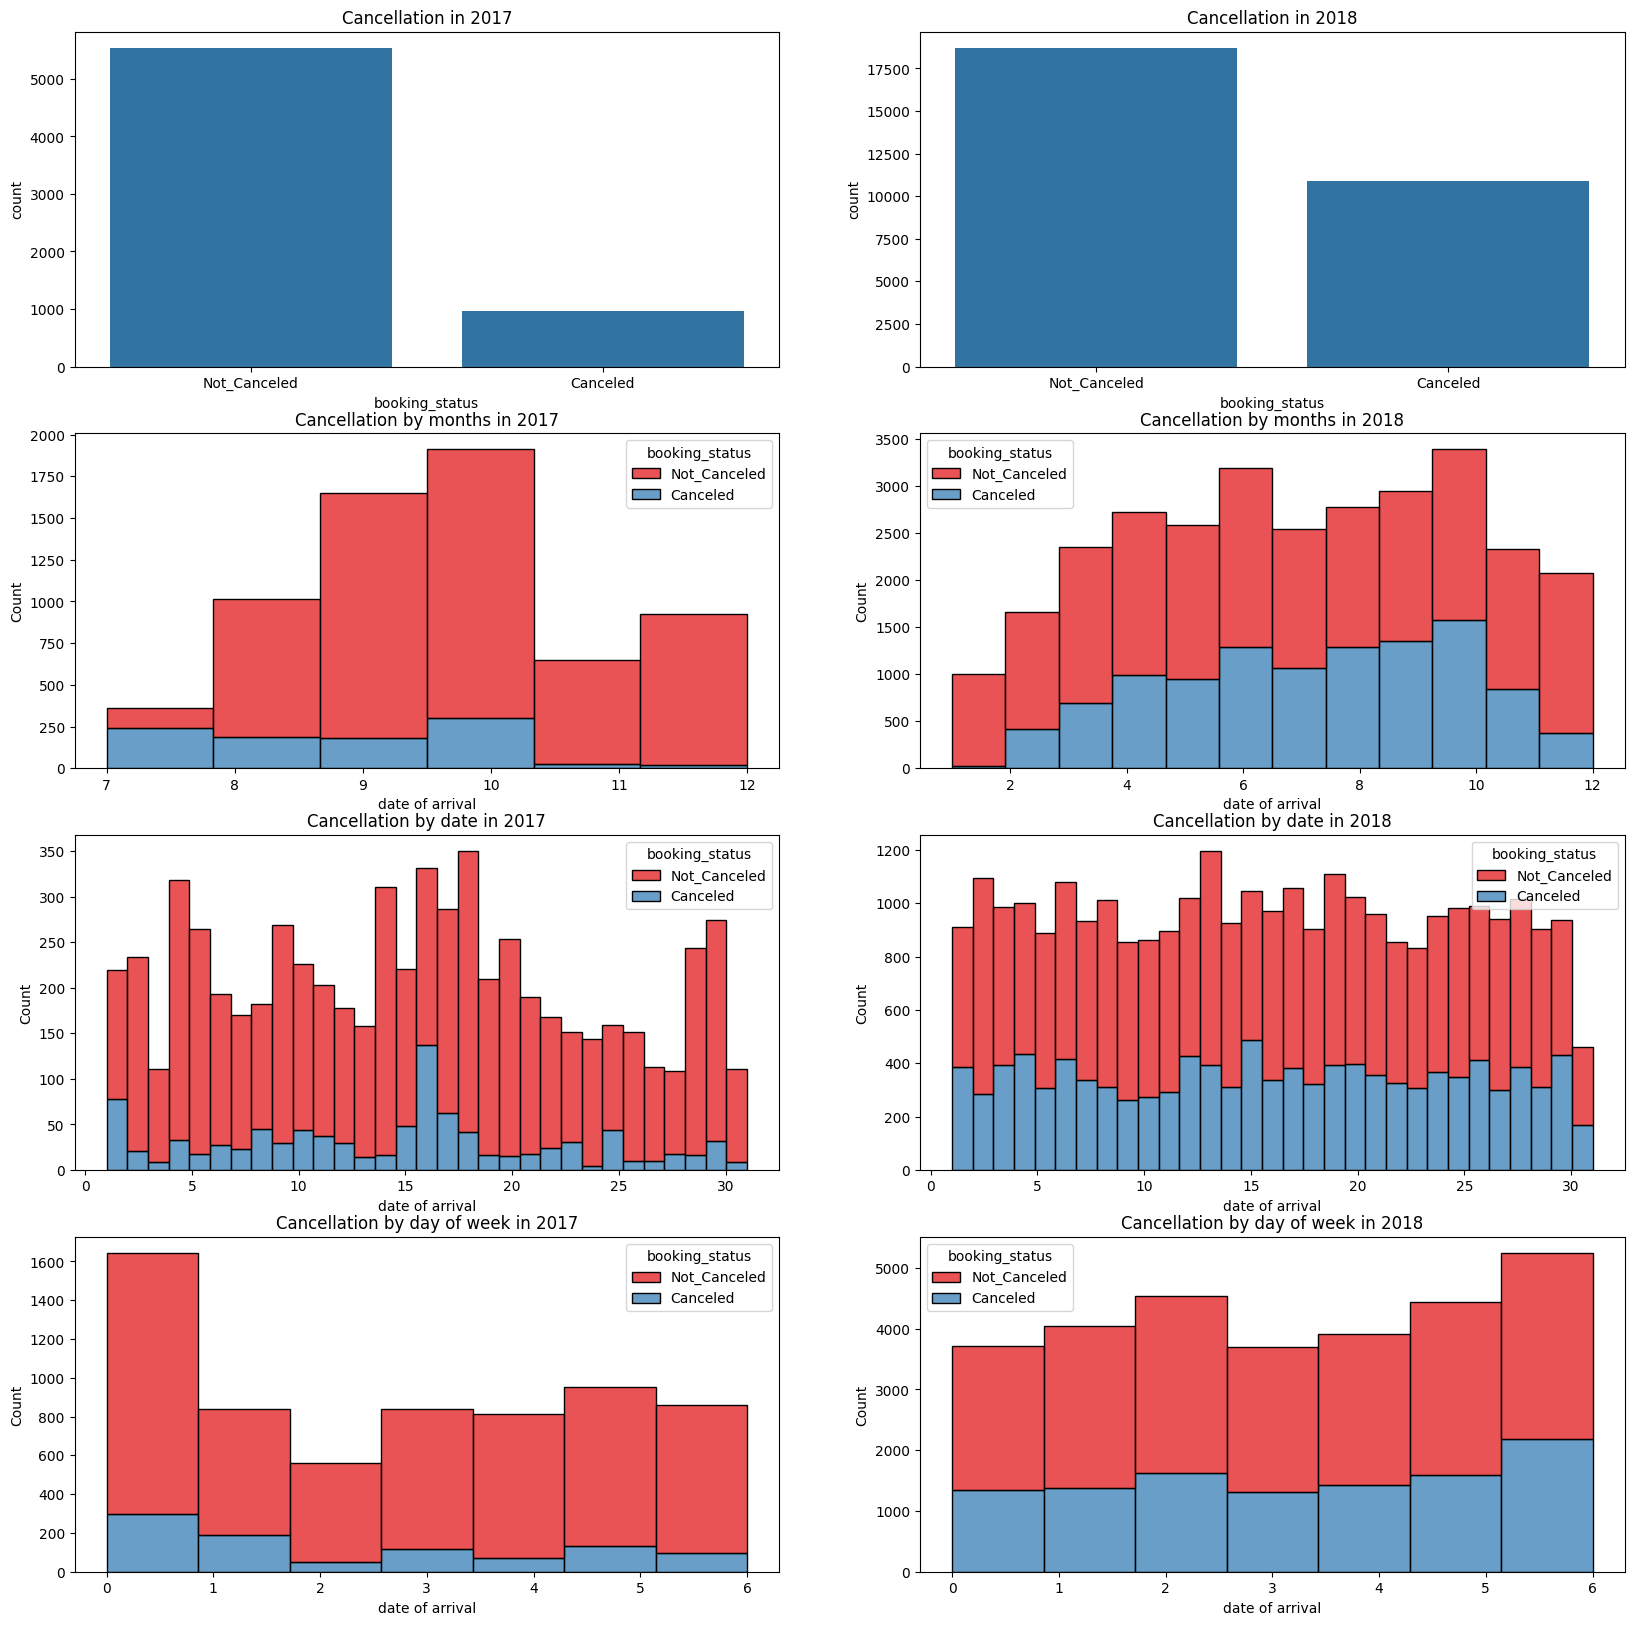

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axes for subplots
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Filter data for 2017 and 2018
df_2017 = hotel_data[hotel_data['date of arrival'].dt.year == 2017]
df_2018 = hotel_data[hotel_data['date of arrival'].dt.year == 2018]

# Year-wise cancellations
sns.countplot(x='booking_status', data=df_2017, ax=ax[0, 0]).set_title('Cancellation in 2017')
sns.countplot(x='booking_status', data=df_2018, ax=ax[0, 1]).set_title('Cancellation in 2018')

# Month-wise cancellations
sns.histplot(x=df_2017['date of arrival'].dt.month, data=df_2017, ax=ax[1, 0], bins=6, hue='booking_status', palette='Set1', multiple='stack').set_title('Cancellation by months in 2017')
sns.histplot(x=df_2018['date of arrival'].dt.month, data=df_2018, ax=ax[1, 1], bins=12, hue='booking_status', palette='Set1', multiple='stack').set_title('Cancellation by months in 2018')

# Date-wise cancellations
sns.histplot(x=df_2017['date of arrival'].dt.day, data=df_2017, ax=ax[2, 0], bins=31, hue='booking_status', palette='Set1', multiple='stack').set_title('Cancellation by date in 2017')
sns.histplot(x=df_2018['date of arrival'].dt.day, data=df_2018, ax=ax[2, 1], bins=31, hue='booking_status', palette='Set1', multiple='stack').set_title('Cancellation by date in 2018')

# Day of week-wise cancellations
sns.histplot(x=df_2017['date of arrival'].dt.dayofweek, data=df_2017, ax=ax[3, 0], bins=7, hue='booking_status', palette='Set1', multiple='stack').set_title('Cancellation by day of week in 2017')
sns.histplot(x=df_2018['date of arrival'].dt.dayofweek, data=df_2018, ax=ax[3, 1], bins=7, hue='booking_status', palette='Set1', multiple='stack').set_title('Cancellation by day of week in 2018')

# Show plot
plt.show()

 As we know that dataset mostly has reservations from 2018, despite of that, the number of reservations cancelled in 2018 is way higher than 2017. In 2017, nearly 5500 reservations were not cancelled and nearly 1000 where cancelled. However in 2018, 17500 reservations were not cancelled and more than 10000 reservations were cancelled. This shows that rate of reservation cancellation was much higher in 2018

Coming to the reservation cancellation according to the months, in 2017 reservations made in July and October had the highest. In addtion to that July had the least number of reservations made but still it has highest cancellation, which points some particular reason, not specified by the data. In 2018, June and October had the highest number of reservations made.

Now, we will look at the reservation cancellations by date of the month. In 2017, most reservations were cancelled for 16th and peculiarly on 1st of the month. In 2018, the number of cancellations were more in second and first week.

Coming to the day wise cancellation, in 2017 Sundays had the highest number of cancellations. In 2018, Saturdays had the highest number of cancellations.

###Services and Cancellation

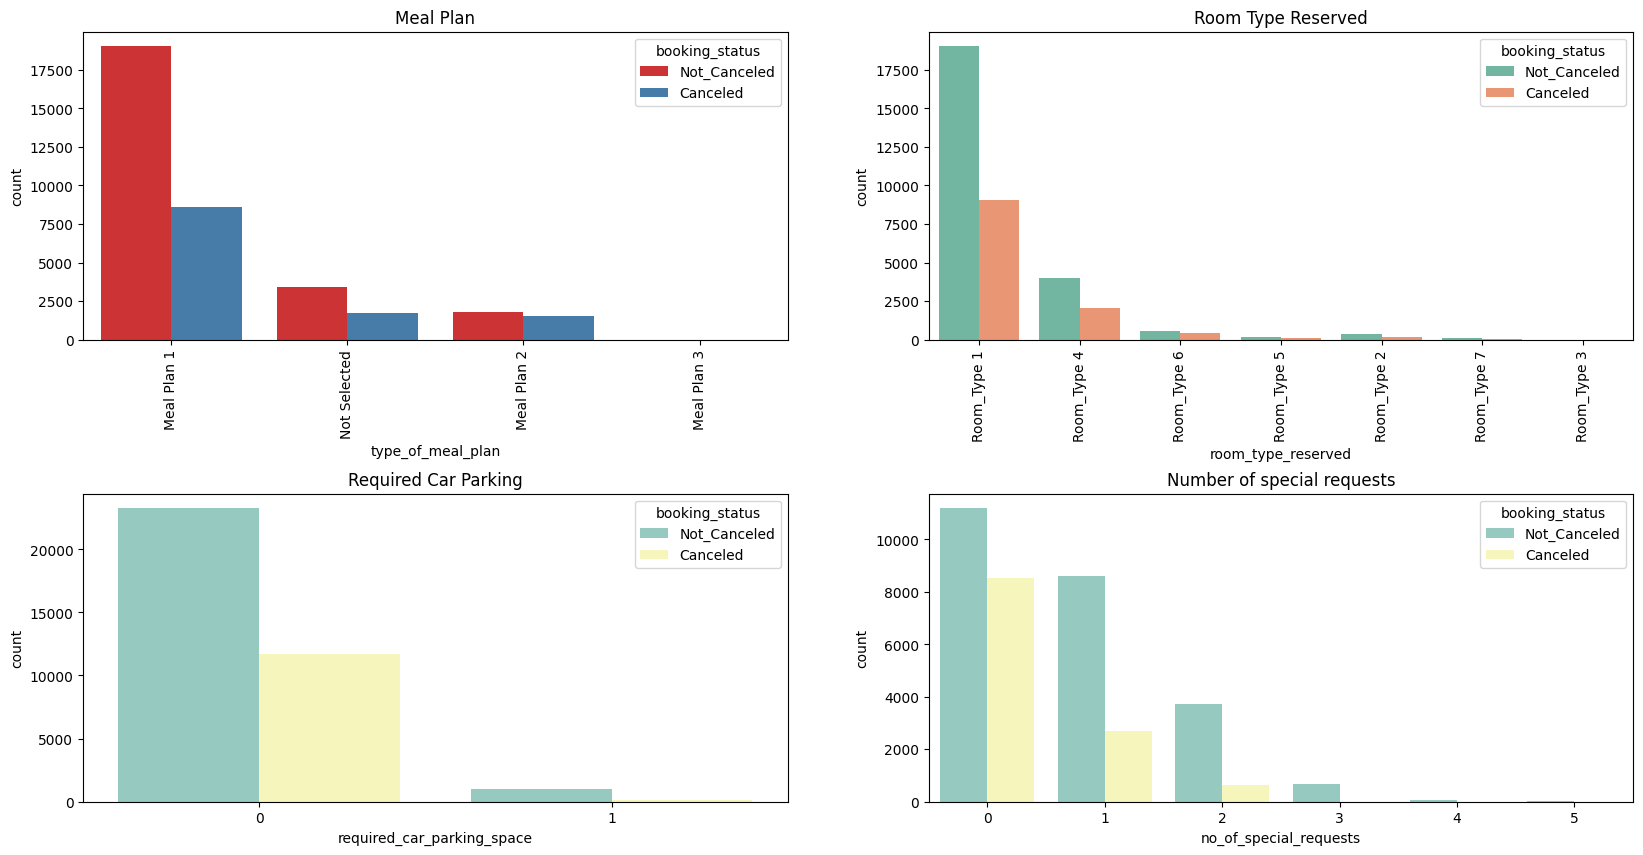

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)

# Plot 'Meal Plan' with a specific color palette
sns.countplot(x='type_of_meal_plan', data=data, ax=ax[0, 0], hue='booking_status', palette='Set1').set_title('Meal Plan')
ax[0, 0].xaxis.set_tick_params(rotation=90)

# Plot 'Room Type Reserved' with a different color palette
sns.countplot(x='room_type_reserved', data=data, ax=ax[0, 1], hue='booking_status', palette='Set2').set_title('Room Type Reserved')
ax[0, 1].xaxis.set_tick_params(rotation=90)

# Plot 'Required Car Parking' with another color palette
sns.countplot(x='required_car_parking_space', data=data, ax=ax[1, 0], hue='booking_status', palette='Set3').set_title('Required Car Parking')

# Plot 'Number of special requests' with a valid color palette
# Use 'Set3' instead of 'Set4' or explore other valid palette names
sns.countplot(x='no_of_special_requests', data=data, ax=ax[1, 1], hue='booking_status', palette='Set3').set_title('Number of special requests')

# Show plot
plt.show()

In the above graphs, we can see that the ratio of cancelled and not cancelled reservations is almost same for all the services. Therefore, we can conclude that the services provided by the hotel does not have any impact on the reservation cancellation.

###Lead time and Cancellation

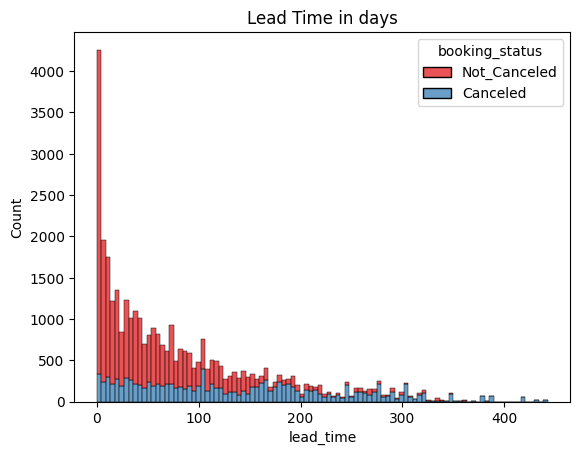

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Plot 'Lead Time in days' with specific settings
sns.histplot(x='lead_time', data=data, bins=100, hue='booking_status', multiple='stack', palette='Set1').set_title('Lead Time in days')

# Show plot
plt.show()


With increase in lead time, the number of reservation cancellations also increases. The differnce in the number of reservations cancelled and not cancelled decreases as the lead time increases. This could mean that the guest who have lead time very less are less likely to cancel the reservation as compared to the guest who have more lead time.

###Market Segment and Cancellation

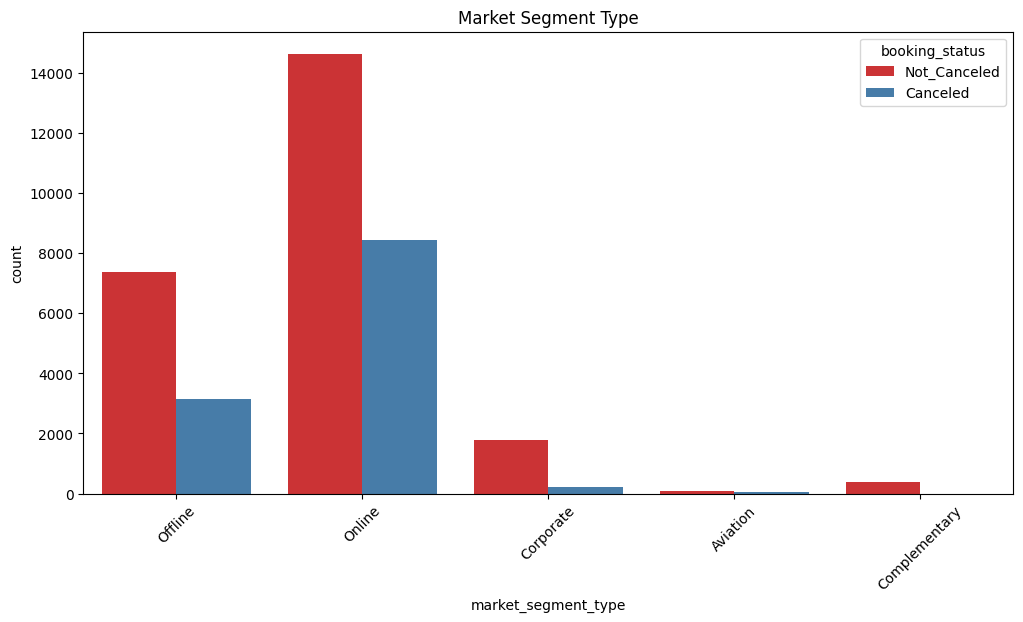

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='market_segment_type', data=data, hue='booking_status', palette='Set1').set_title('Market Segment Type')

# Rotate x-axis labels for better readability if necessary
plt.xticks(rotation=45)

# Show plot
plt.show()

Here most of the reservations are made through online platforms and thus it has the most number of cancellations. The second most common market segment is offline, which has the second most number of cancellations.

###Guest's previous experience and Cancellation

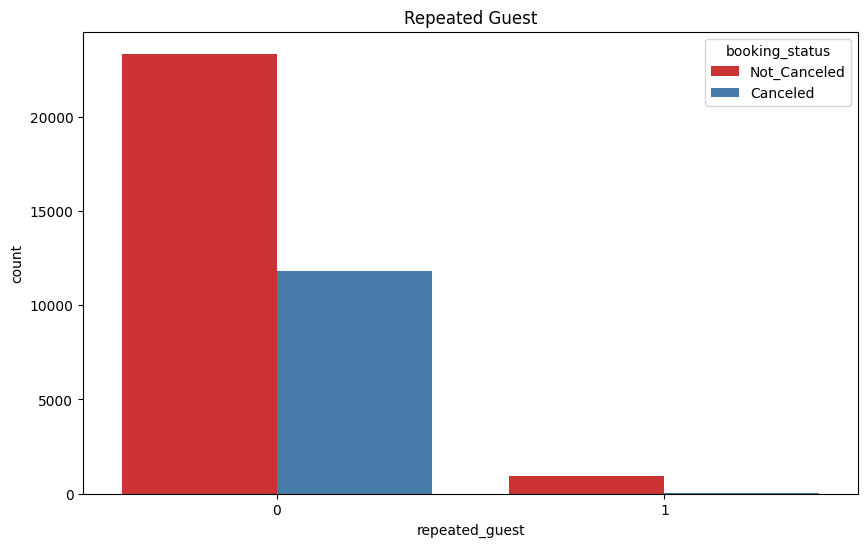

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='repeated_guest', data=data, hue='booking_status', palette='Set1').set_title('Repeated Guest')

# Show plot
plt.show()

The previous guest are much less likely to cancel the reservation as compared to the new guest.

###Average room price and Cancellation

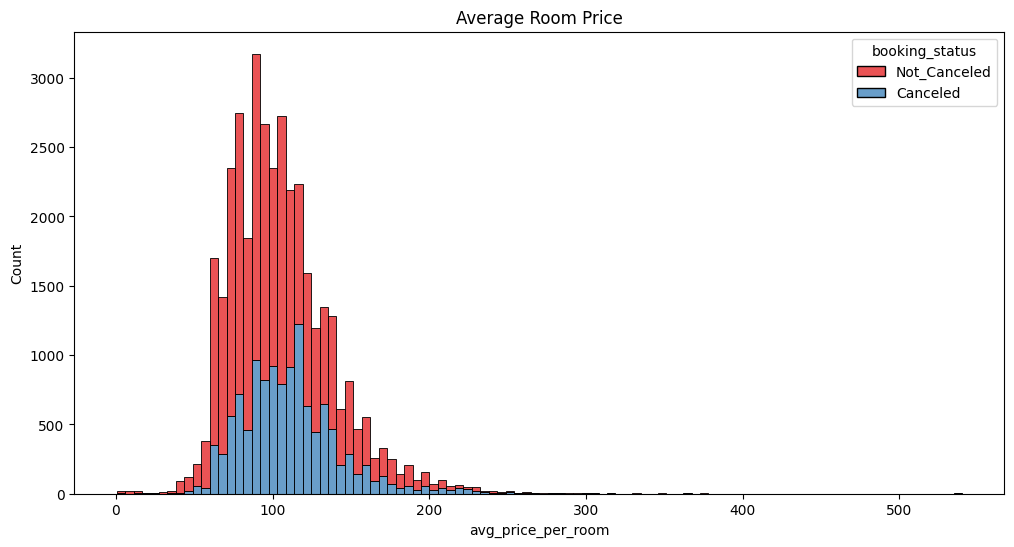

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign hotel_data to a variable named data
data = hotel_data

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(x='avg_price_per_room', data=data, bins=100, hue='booking_status', multiple='stack', palette='Set1').set_title('Average Room Price')

# Show plot
plt.show()

Most of the room prices are between 75-150 and the number of reservations cancellation mostly occur in the same range. Therefore, there is no relation between the room price and reservation cancellation.

##5.Data Preparation for Model Training

###Outlier Removal using IQR

In [42]:
# Assign hotel_data to df
df = hotel_data

# Specify the columns for outlier removal
cols = ['lead_time', 'avg_price_per_room']

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Remove outliers
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

###Label Encoding

In [43]:
from sklearn.preprocessing import LabelEncoder
#label encoding object
le = LabelEncoder()

#columns to be encoded
cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']

#label encoding
for col in cols:
    le.fit(df[col])
    df[col] = le.transform(df[col])
    print(col, df[col].unique())

type_of_meal_plan [0 3 1 2]
room_type_reserved [0 3 5 4 1 6 2]
market_segment_type [3 4 2 0 1]
booking_status [1 0]


###Feature Scaling

In [44]:
from sklearn.preprocessing import StandardScaler
#standardizing the data
scaler = StandardScaler()
df[['lead_time', 'avg_price_per_room']] = scaler.fit_transform(df[['lead_time', 'avg_price_per_room']])

###Correlation Matrix Heatmap

<Axes: >

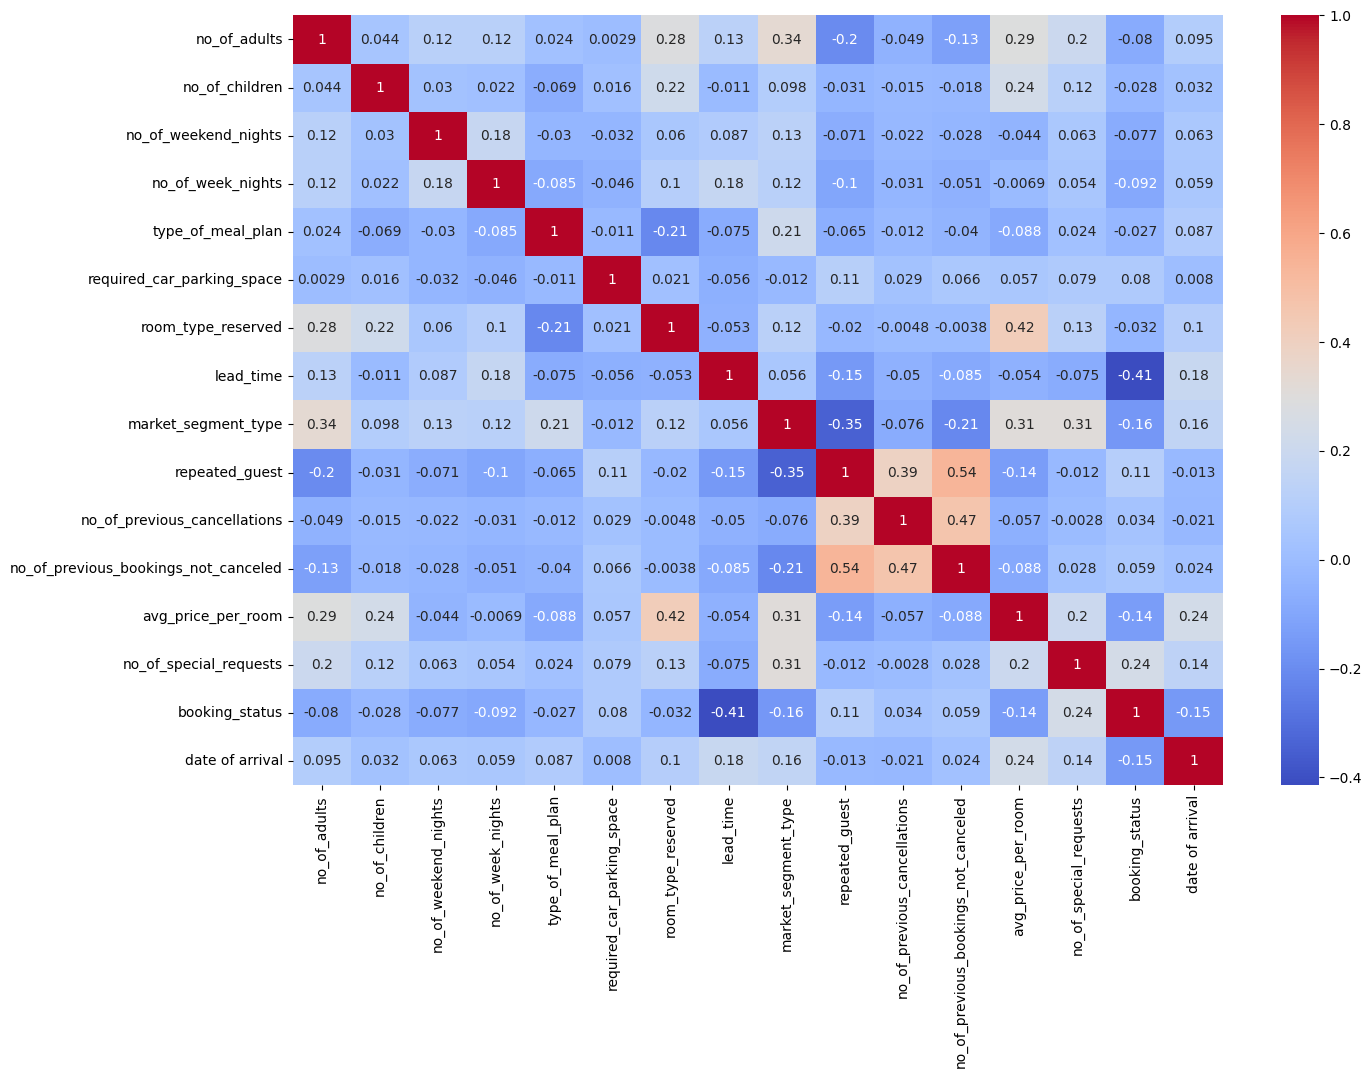

In [45]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

###Train Test Split

In [46]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date of arrival
0,2,0,1,2,0,0,0,2.018766,3,0,0,0,-1.373012,0,1,2017-10-02
1,2,0,2,3,3,0,0,-0.987059,4,0,0,0,0.157135,1,1,2018-11-06
2,1,0,2,1,0,0,0,-1.041960,4,0,0,0,-1.556571,0,0,2018-02-28
3,2,0,0,2,0,0,0,1.840338,4,0,0,0,-0.088099,0,0,2018-05-20
4,2,0,1,1,3,0,0,-0.396874,4,0,0,0,-0.290014,0,0,2018-04-11


In [47]:
# Having issue with the model training due to this column
df.drop(columns=['date of arrival'], inplace=True)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('booking_status', axis=1), df['booking_status'], test_size=0.2, random_state=42)

##6.Predictive Modeling

In [50]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [51]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier(),
    "CatBoost": cb.CatBoostClassifier(verbose=0),
    "LogitBoost": LogitBoost()
}


In [65]:
from sklearn.metrics import confusion_matrix
# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    predictions = {}
    feature_importances = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        predictions[name] = y_pred

        print(f"{name} results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}\n")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Feature importance
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({'Features': X_train.columns, 'Importance': model.feature_importances_})
            feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
            feature_importance.reset_index(drop=True, inplace=True)
            feature_importances[name] = feature_importance

            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Features', data=feature_importance)
            plt.title(f'Feature Importance for {name}')
            plt.show()

    return results, predictions, feature_importances


Logistic Regression results:
Accuracy: 0.7654
Precision: 0.7387
Recall: 0.7681
F1 Score: 0.7453



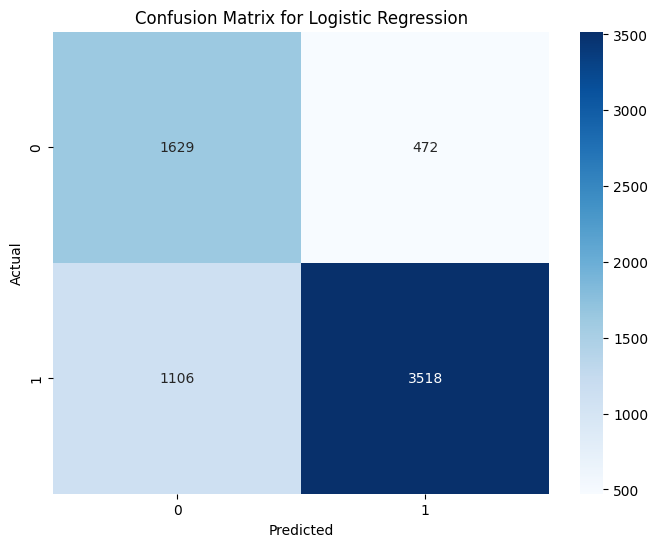

Decision Tree results:
Accuracy: 0.8415
Precision: 0.8134
Recall: 0.8305
F1 Score: 0.8206



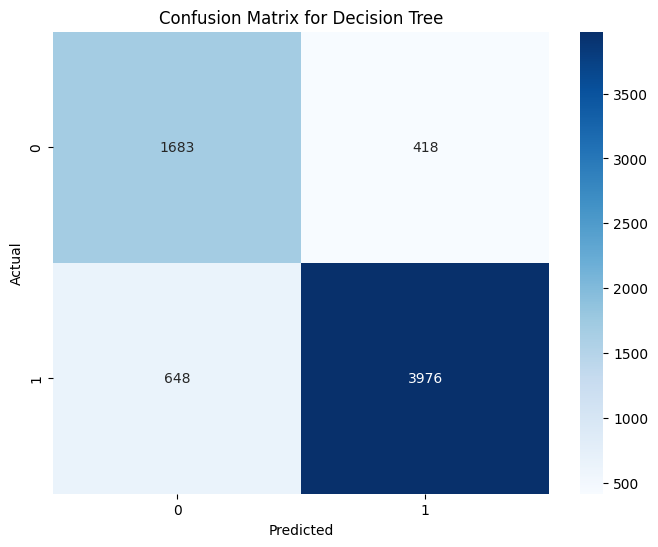

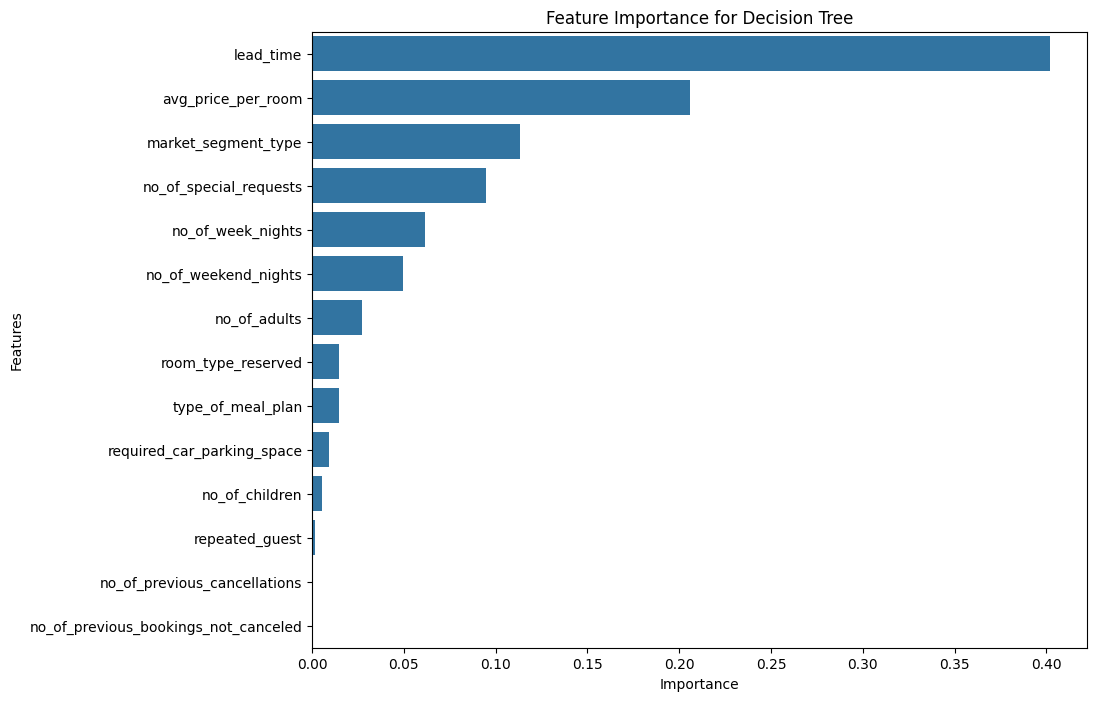

Random Forest results:
Accuracy: 0.8746
Precision: 0.8524
Recall: 0.8587
F1 Score: 0.8554



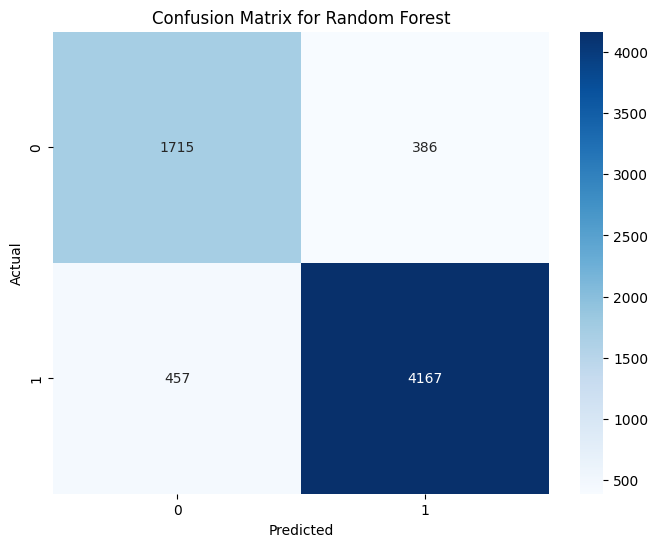

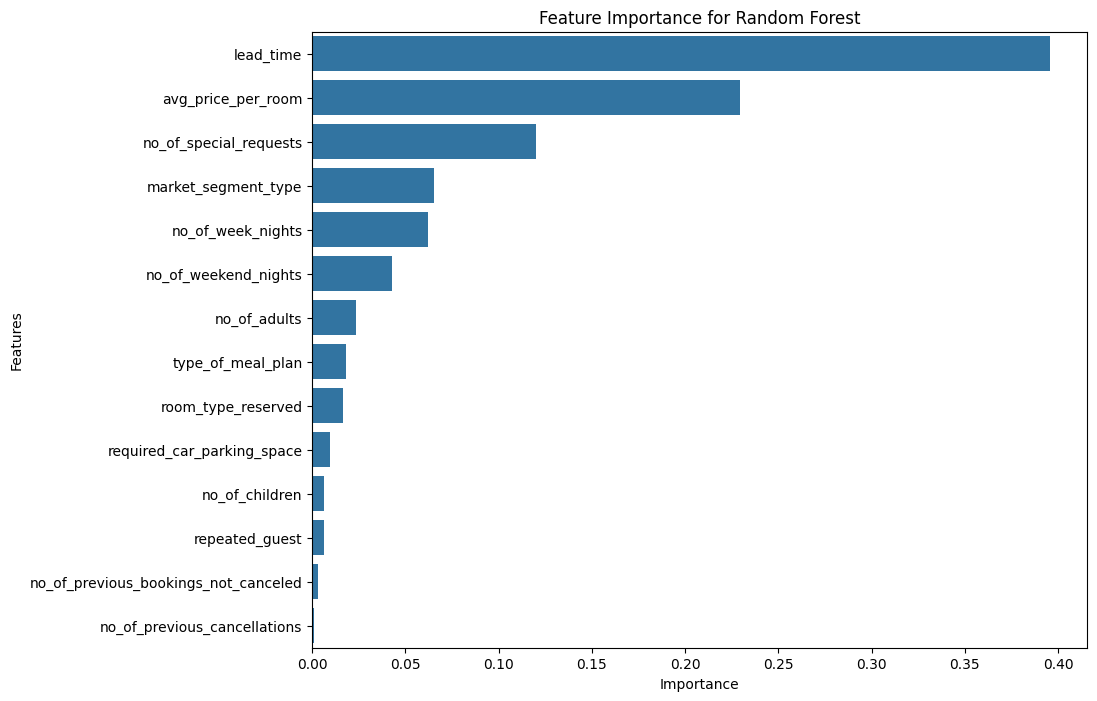

AdaBoost results:
Accuracy: 0.7932
Precision: 0.7633
Recall: 0.7887
F1 Score: 0.7715



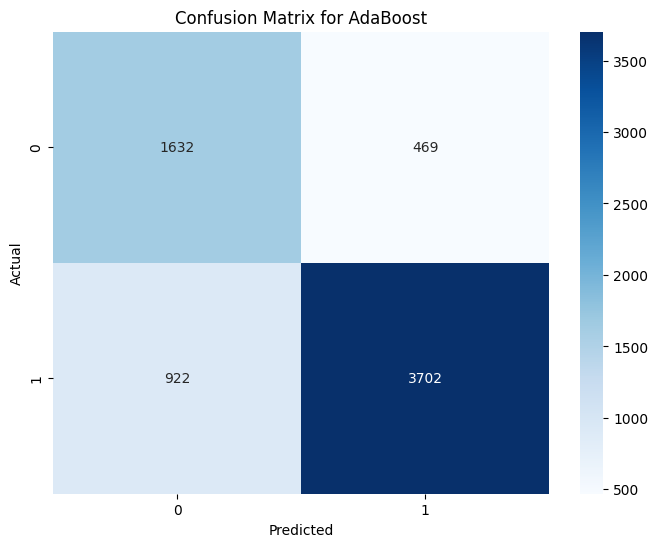

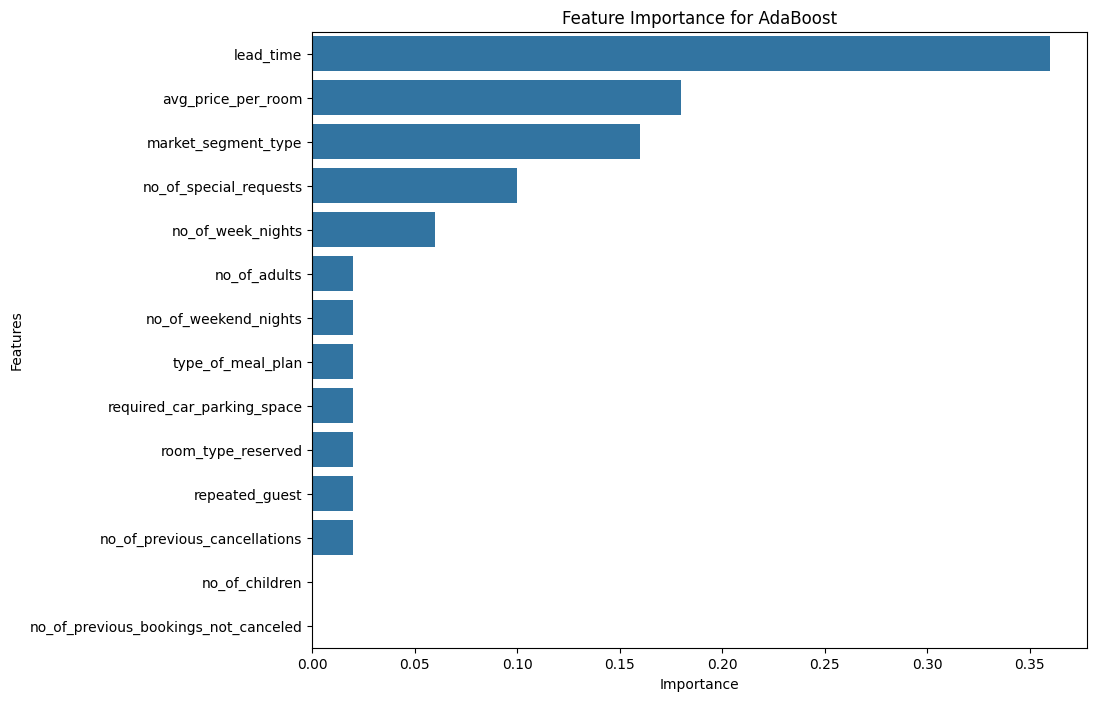

Gradient Boosting results:
Accuracy: 0.8225
Precision: 0.7927
Recall: 0.8118
F1 Score: 0.8003



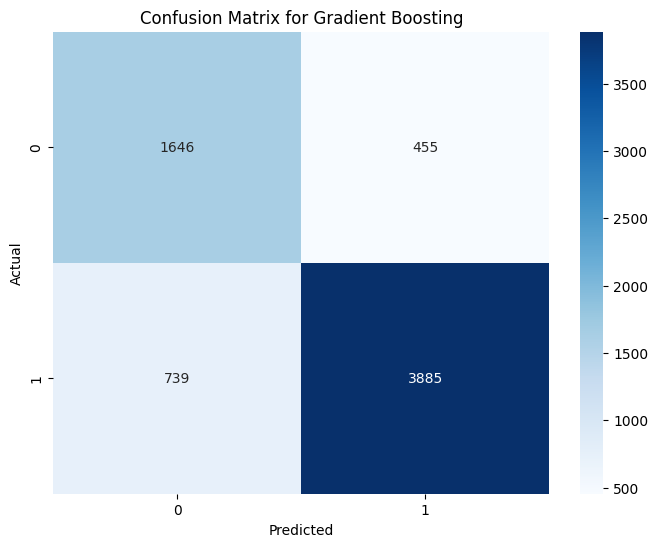

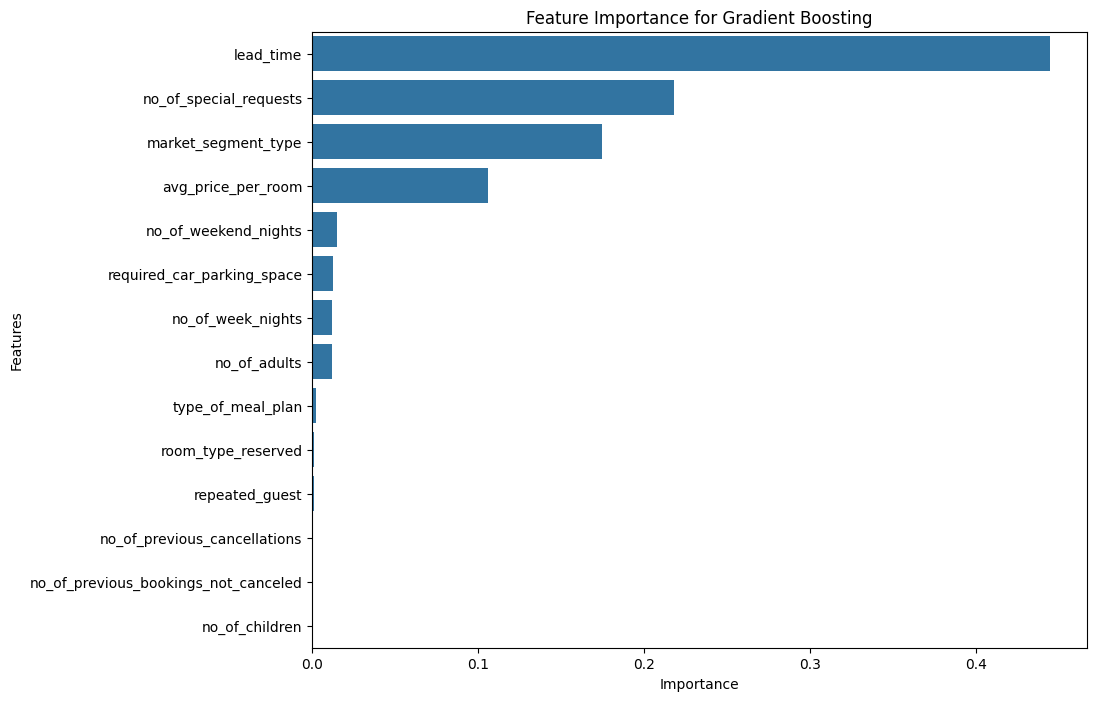

XGBoost results:
Accuracy: 0.8562
Precision: 0.8298
Recall: 0.8464
F1 Score: 0.8369



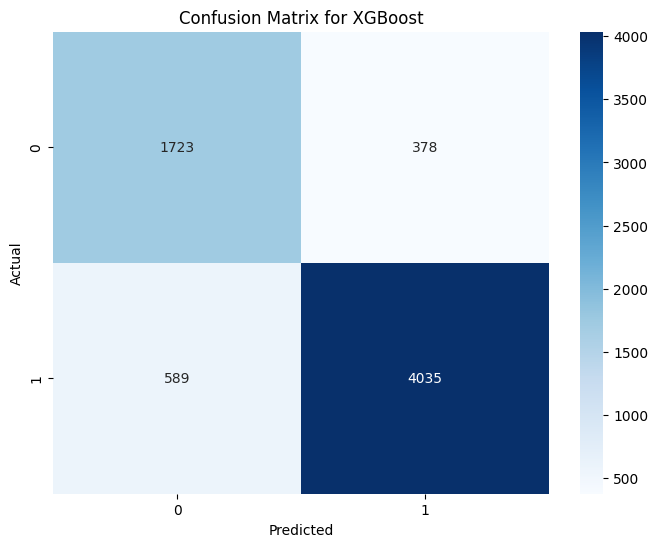

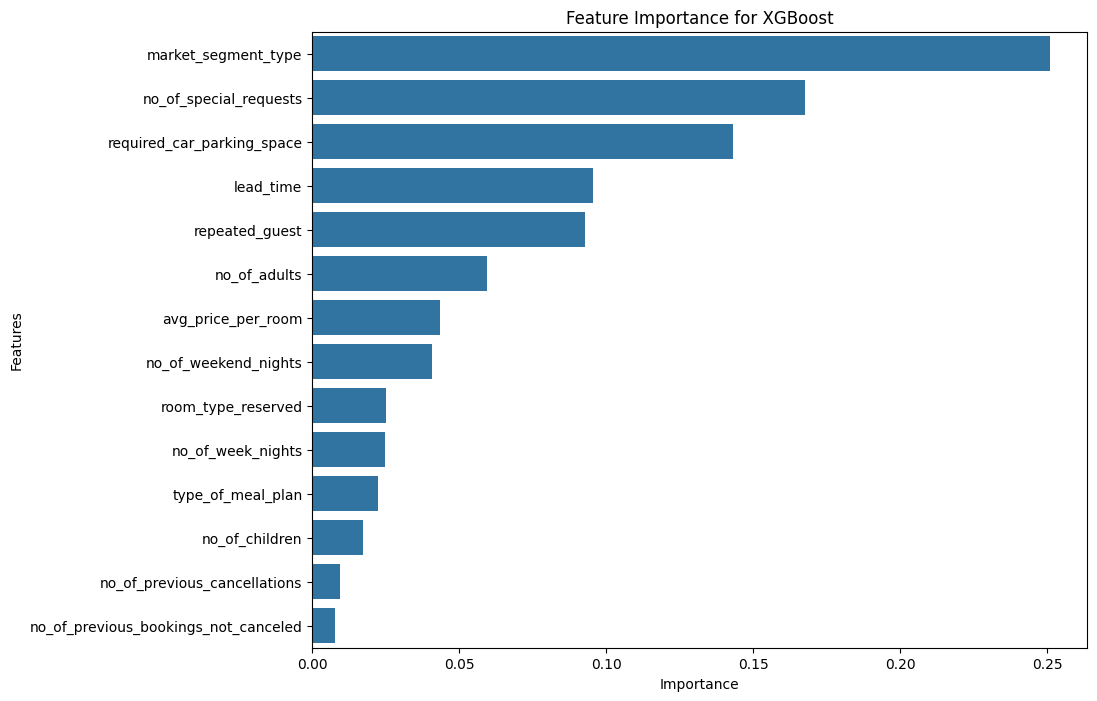

[LightGBM] [Info] Number of positive: 18650, number of negative: 18650
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 37300, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM results:
Accuracy: 0.8578
Precision: 0.8325
Recall: 0.8421
F1 Score: 0.8370



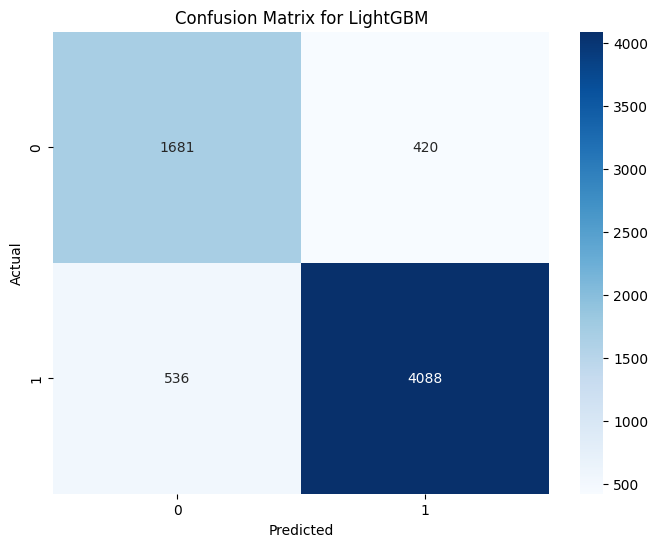

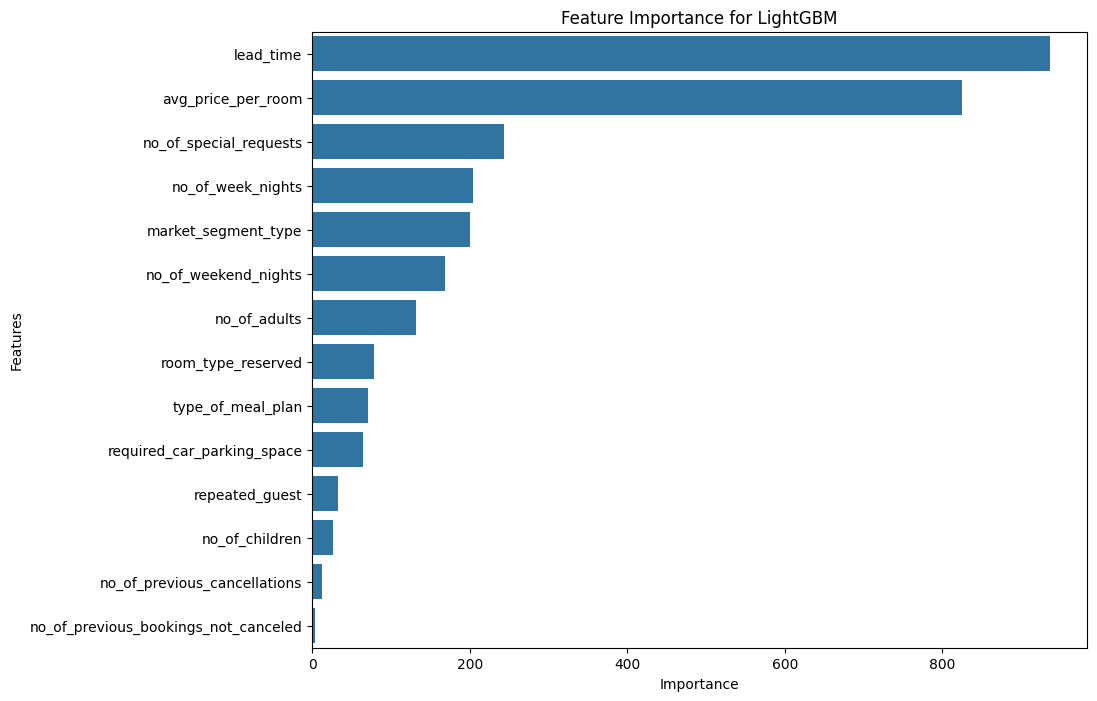

CatBoost results:
Accuracy: 0.8593
Precision: 0.8339
Recall: 0.8456
F1 Score: 0.8392



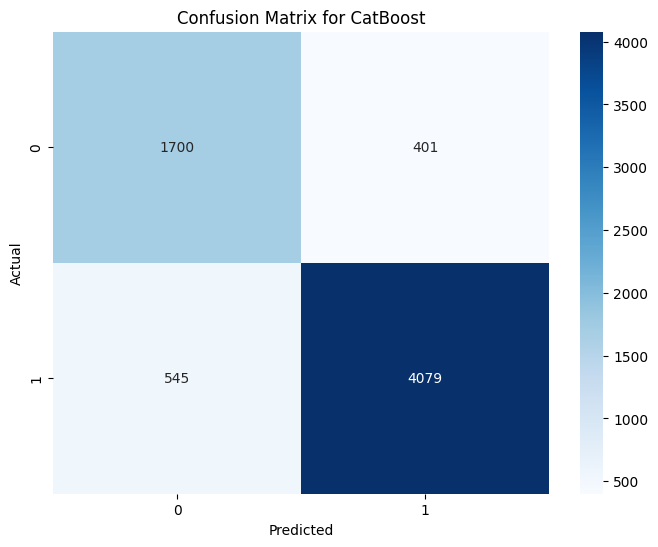

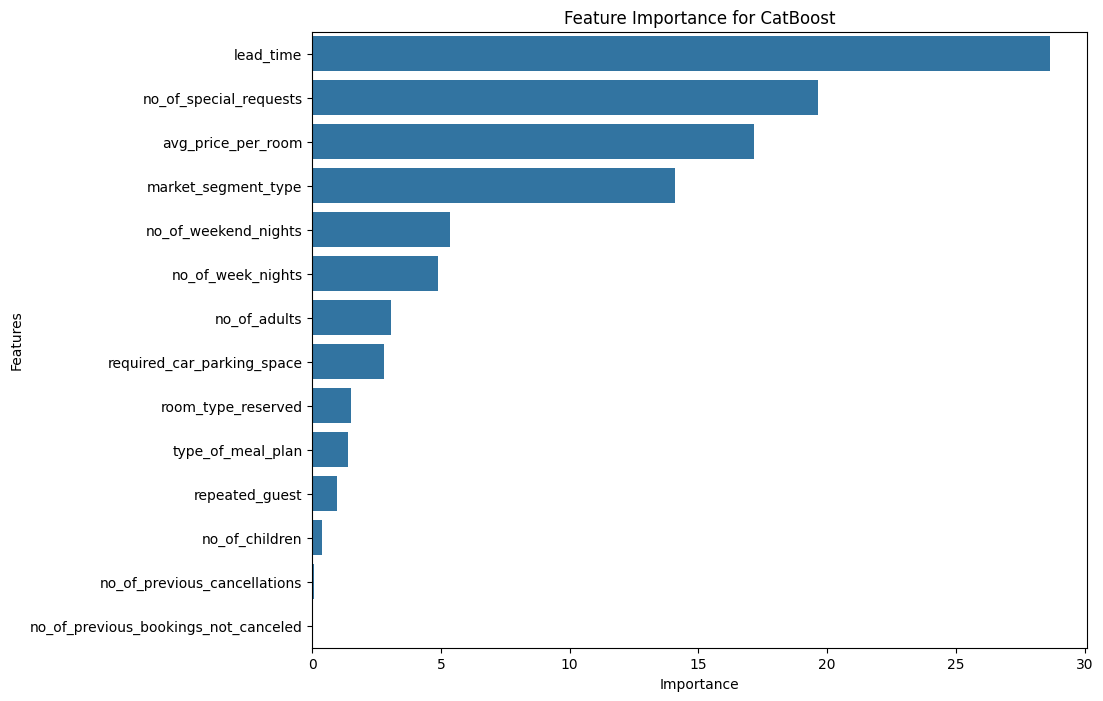

LogitBoost results:
Accuracy: 0.7981
Precision: 0.7676
Recall: 0.7912
F1 Score: 0.7758



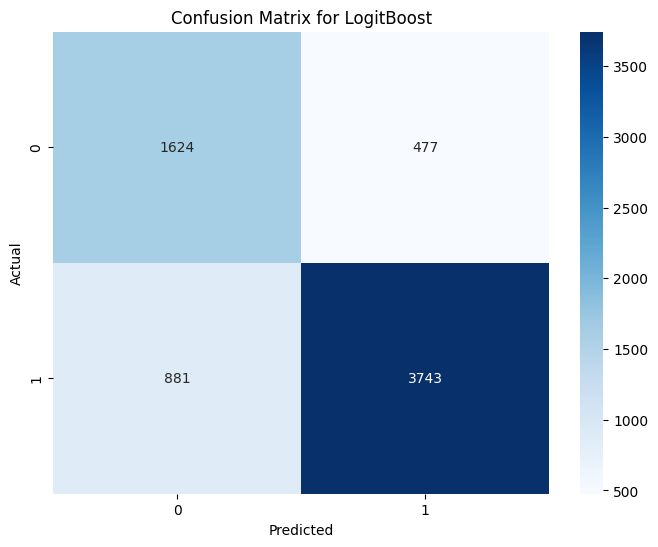

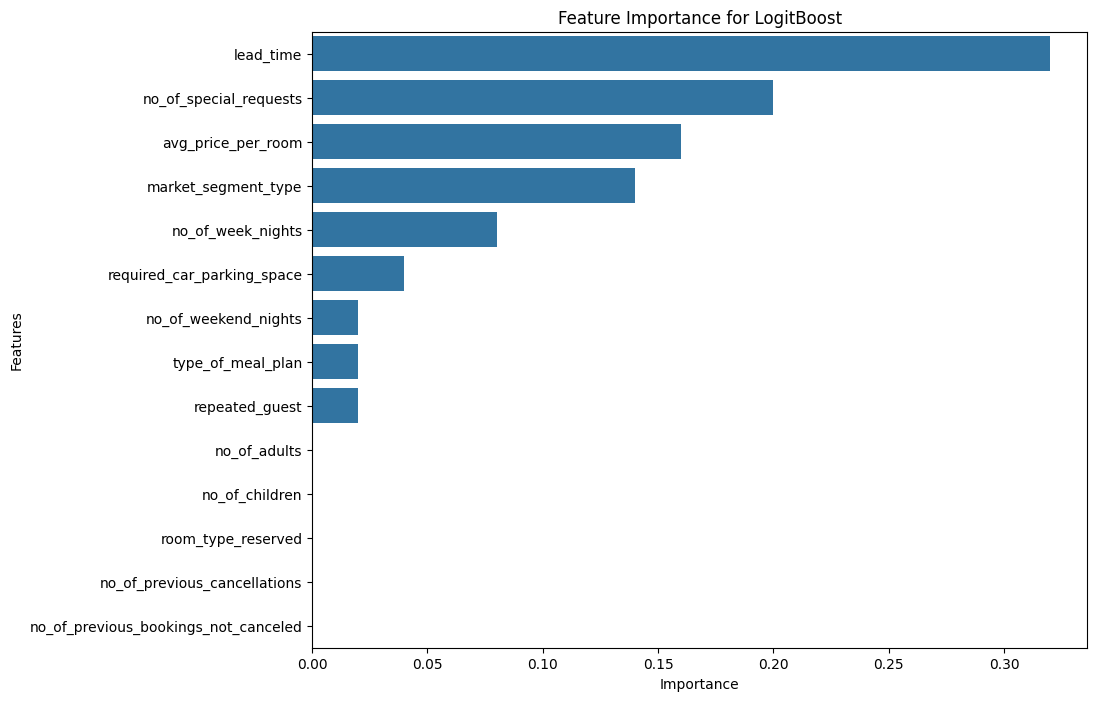

In [66]:
# Train and evaluate the models
results, predictions, feature_importances = train_and_evaluate(models, X_train_resampled, X_test, y_train_resampled, y_test)

In [68]:
# Display results in a table format
results_df = pd.DataFrame(results)
results_df

,Logistic Regression,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost,LightGBM,CatBoost,LogitBoost
accuracy,0.765353,0.841487,0.874647,0.793160,0.822454,0.856208,0.857844,0.859331,0.798067
precision,0.738658,0.813439,0.852408,0.763277,0.792654,0.829793,0.832532,0.833865,0.767635
recall,0.768079,0.830454,0.858723,0.788689,0.811809,0.846353,0.842089,0.845638,0.791219
f1_score,0.745254,0.820634,0.855427,0.771512,0.800320,0.836935,0.836957,0.839209,0.775808


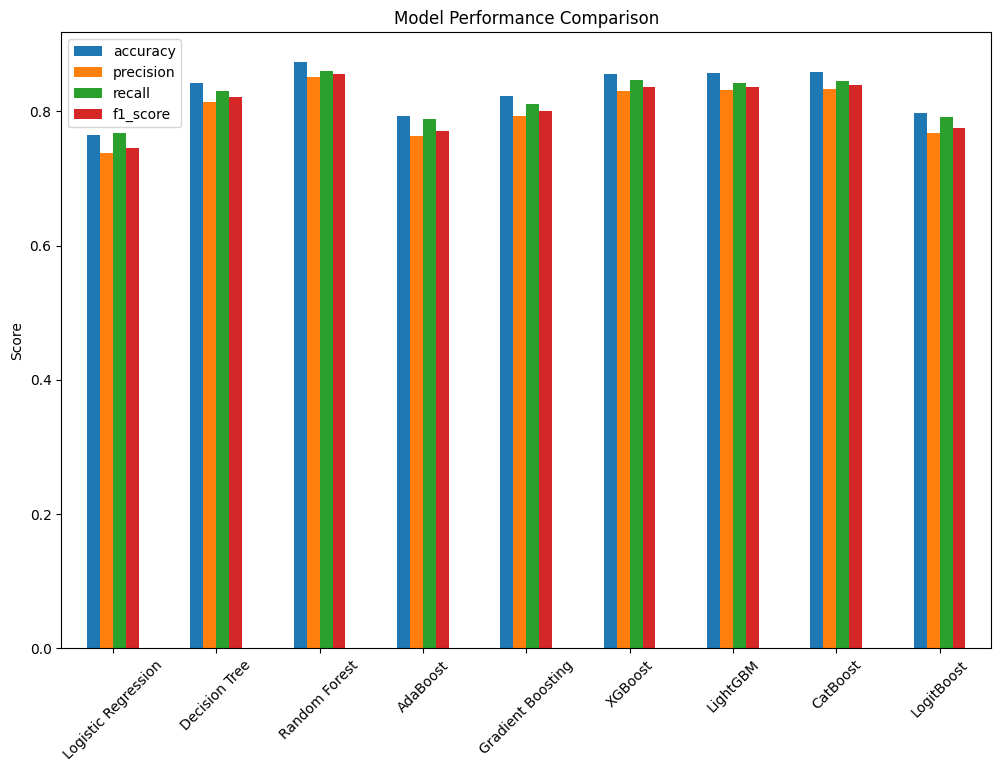

In [63]:
# Plotting the results
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

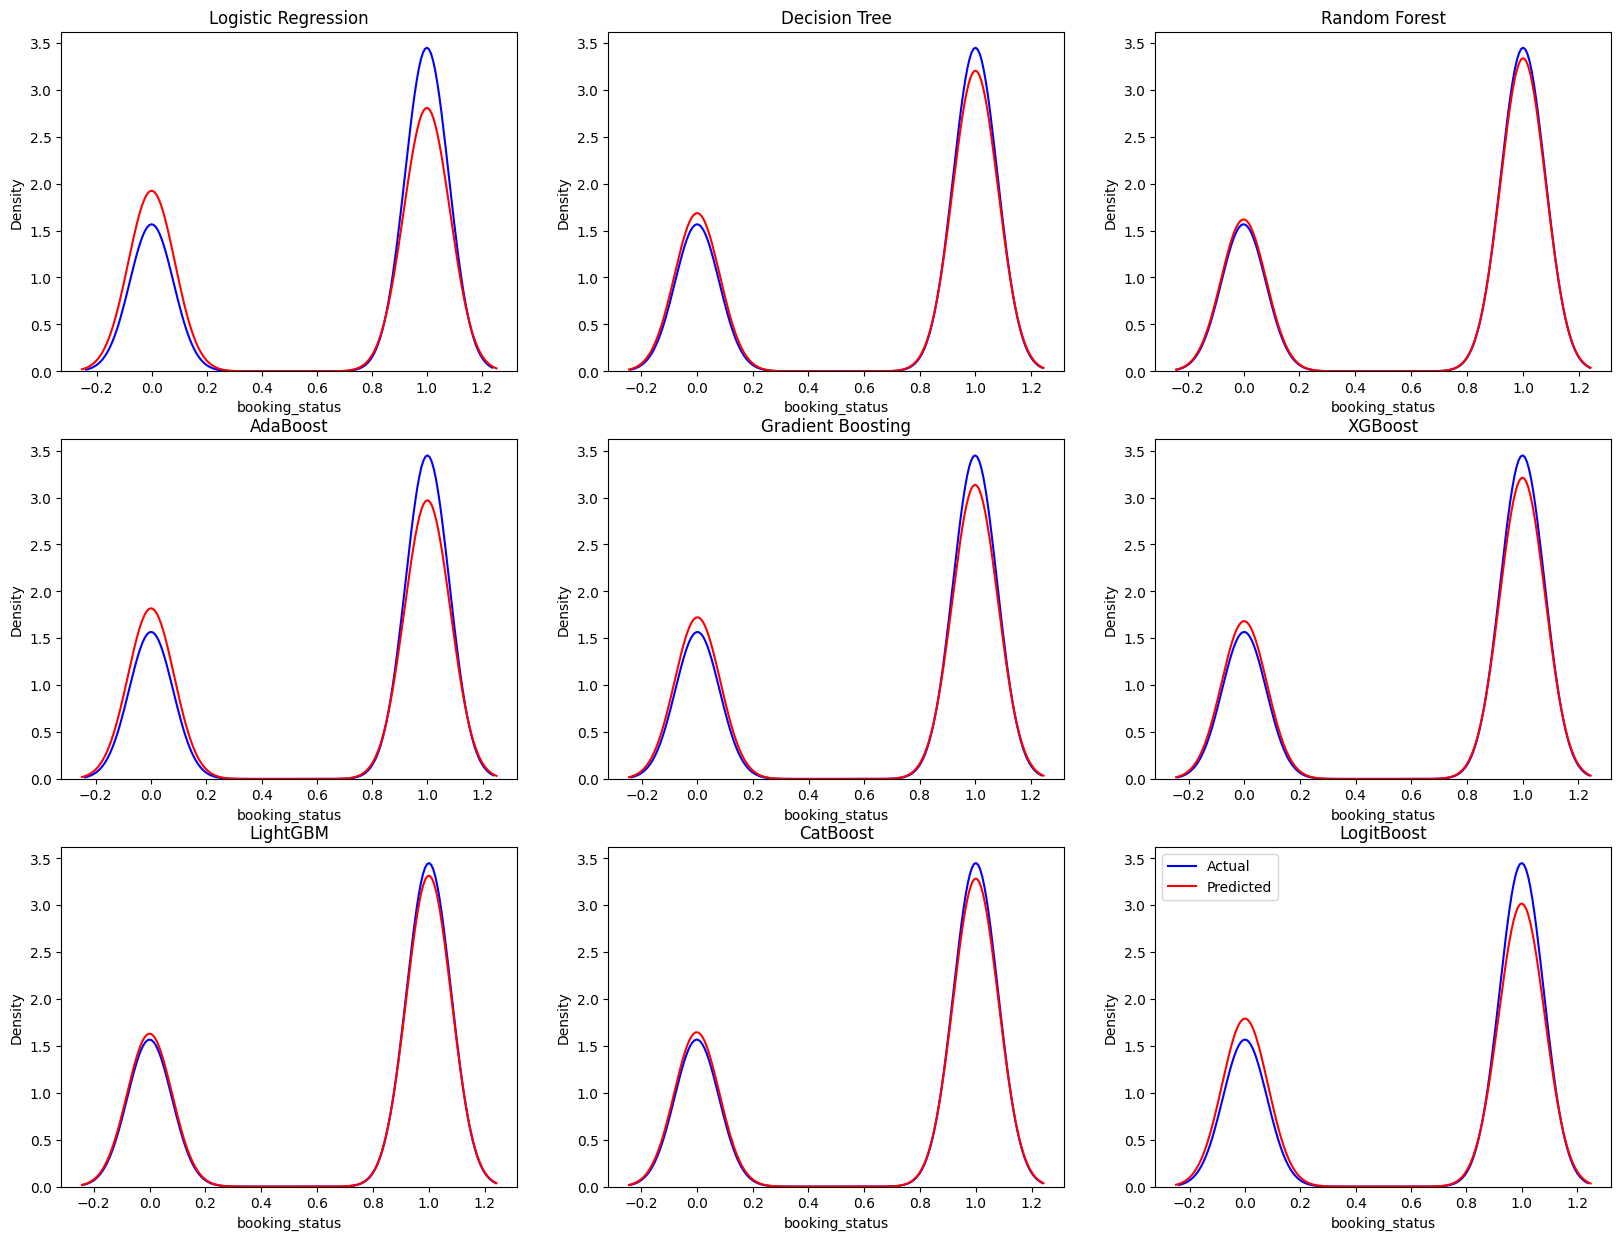

In [64]:
# Plotting the distributions
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

model_names = list(models.keys())

for i, name in enumerate(model_names):
    sns.kdeplot(y_test, ax=ax[i//3, i%3], label='Actual', color='blue')
    sns.kdeplot(predictions[name], ax=ax[i//3, i%3], label='Predicted', color='red')
    ax[i//3, i%3].set_title(name)

plt.legend()
plt.show()

##7.Statistical Analysis

In [ ]:
from scipy.stats import ttest_ind
# Create a new feature total_nights
hotel_data['total_nights'] = hotel_data['no_of_weekend_nights'] + hotel_data['no_of_week_nights']

# Separate the data into canceled and not canceled bookings
canceled = hotel_data[hotel_data['booking_status'] == 'Canceled']
not_canceled = hotel_data[hotel_data['booking_status'] == 'Not_Canceled']

# Perform t-tests
ttest_lead_time = ttest_ind(canceled['lead_time'], not_canceled['lead_time'], equal_var=False)
ttest_avg_price = ttest_ind(canceled['avg_price_per_room'], not_canceled['avg_price_per_room'], equal_var=False)
ttest_special_requests = ttest_ind(canceled['no_of_special_requests'], not_canceled['no_of_special_requests'], equal_var=False)
ttest_total_nights = ttest_ind(canceled['total_nights'], not_canceled['total_nights'], equal_var=False)

# Print the t-test results with p-values
ttest_results = {
    'Lead Time': ttest_lead_time,
    'Average Price per Room': ttest_avg_price,
    'Number of Special Requests': ttest_special_requests,
    'Total Nights': ttest_total_nights
}

p_values = {key: result.pvalue for key, result in ttest_results.items()}
p_values


{'Lead Time': 0.0,
 'Average Price per Room': 2.3570548204656775e-175,
 'Number of Special Requests': 0.0,
 'Total Nights': 6.386819349884483e-75}

The results of the analysis indicate statistically significant differences between canceled and not canceled reservations for all tested numerical variables. The lead time, with a p-value of 0.0, shows a significant difference, suggesting it is a strong predictor of cancellations. The average price per room, with a p-value of 2.36e-175, also demonstrates a significant difference, implying that room cost may influence cancellation likelihood. Additionally, the number of special requests, with a p-value of 0.0, indicates that guests who make special requests behave differently regarding cancellations. Lastly, the total number of nights booked, with a p-value of 6.39e-75, highlights the duration of the stay as a factor in the cancellation decision. These results suggest that lead time, average price per room, number of special requests, and total nights are valuable predictors and should be considered in any predictive models developed to forecast cancellations.

##8.Conclusion

From the Exploratory Data Analysis, the most of the reservations were made for 2 adults with no children which could probably for a couple had highest cancellation count. In addtion to that, the cancellation count of reservations decreases when there are children involved. Most of the reservations were made for week nights and had exponentially higher cancellations as compared to those made for weekend nights.

The year 2018 had higher cancellation rate as compared to 2017, with most of the cancellation done in month of July and October. Upon visualization of the services opted during reservation with booking status, it was found that the services opted during reservation does not have any impact on the reservation cancellation.

The lead time had a huge impact on the reservation cancellation, which has been evident from feature importance as well. The guest who have lead time very less are less likely to cancel the reservation as compared to the guest who have more lead time. Therefore, with increased lead time, the guests have more time to think about the reservation and thus they are more likely to cancel the reservation. So, the hotel should try to take reservations for shorter lead time.

The market segment of the reservation also had an impact on the reservation cancellation. The reservations made through online platforms had the highest number of cancellations. This highlights the hotel's reputation and presence on online platforms. The hotel should try to improve its reputation on online platforms to reduce the reservation cancellation.

Coming to the classification models, Random Forest is considered the best model in this context due to its highest accuracy, and superior precision, recall, and F1 score. These metrics indicate that Random Forest is effective at making accurate predictions while minimizing false positives and false negatives.